In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import partial
from itertools import combinations
import random
import gc
import time
import math

# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import seaborn as sns
from category_encoders import OrdinalEncoder, CountEncoder, CatBoostEncoder, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, LabelEncoder # OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.decomposition import PCA, NMF
from umap import UMAP
from sklearn.decomposition import FastICA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
import shap

# Import libraries for Hypertuning
import optuna

# Import libraries for gradient boosting
import lightgbm as lgb
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process.kernels import RBF
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool

from sklearn.feature_selection import RFE, RFECV
from sklearn.inspection import permutation_importance

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', '.*DataFrame is highly fragmented*')

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

/kaggle/input/ec-mixed-class/mixed_fcfp.csv
/kaggle/input/ec-mixed-class/mixed_desc.csv
/kaggle/input/ec-mixed-class/mixed_ecfp.csv
/kaggle/input/playground-series-s3e18/sample_submission.csv
/kaggle/input/playground-series-s3e18/train.csv
/kaggle/input/playground-series-s3e18/test.csv


In [2]:
# Load Data
filepath = '/kaggle/input/playground-series-s3e18'
generated_filepath = '/kaggle/input/ec-mixed-class'

df_train = pd.read_csv(os.path.join(filepath, 'train.csv'), index_col=[0])
df_test = pd.read_csv(os.path.join(filepath, 'test.csv'), index_col=[0])
original = pd.read_csv(os.path.join(generated_filepath, 'mixed_desc.csv'), index_col=[0])
# original_ecfp = pd.read_csv(os.path.join(generated_filepath, 'mixed_ecfp.csv'), index_col=[0])
# original3_fcfp = pd.read_csv(os.path.join(generated_filepath, 'mixed_fcfp.csv'), index_col=[0])

# Preprocessing for original
df = original['EC1_EC2_EC3_EC4_EC5_EC6'].str.split('_').reset_index()
df_expanded = pd.DataFrame(df['EC1_EC2_EC3_EC4_EC5_EC6'].tolist(), columns=[f'EC{i+1}' for i in range(len(df['EC1_EC2_EC3_EC4_EC5_EC6'].iloc[0]))])
df_expanded['CIDs'] = df['CIDs']
df_expanded = df_expanded[['CIDs'] + [f'EC{i+1}' for i in range(len(df['EC1_EC2_EC3_EC4_EC5_EC6'].iloc[0]))]]
df_expanded.set_index('CIDs', inplace=True)
original = pd.concat([original[df_test.columns], df_expanded.astype(int)], axis=1)

# Define columns
# num_cols = df_test.select_dtypes(include=['int64', 'float64']).columns.tolist()
# cat_cols = df_test.select_dtypes(include=['object']).columns.tolist()
target_cols = [
    'EC1', 
    'EC2'
]
num_cols = [
    'BertzCT',
    'Chi1',
    'Chi1n',
    'Chi1v',
    'Chi2n',
    'Chi2v',
    'Chi3v',
    'Chi4n',
    'EState_VSA1',
    'EState_VSA2',
    'ExactMolWt',
    'FpDensityMorgan1',
    'FpDensityMorgan2',
    'FpDensityMorgan3',
    'HallKierAlpha',
    'HeavyAtomMolWt',
    'Kappa3',
    'MaxAbsEStateIndex',
    'MinEStateIndex',
    'NumHeteroatoms',
    'PEOE_VSA10',
    'PEOE_VSA14',
    'PEOE_VSA6',
    'PEOE_VSA7',
    'PEOE_VSA8',
    'SMR_VSA10',
    'SMR_VSA5',
    'SlogP_VSA3',
    'VSA_EState9',
    'fr_COO',
    'fr_COO2',
    ]
binary_cols = [
    'EC3',
    'EC4',
    'EC5',
    'EC6',
]

df_train['is_generated'] = 1
df_test['is_generated'] = 1
original['is_generated'] = 0

print(f"train shape :{df_train.shape}, ", f"test shape :{df_test.shape}")
print(f"original shape :{original.shape}")


train shape :(14838, 38),  test shape :(9893, 32)
original shape :(1039, 38)


In [3]:

def set_frame_style(df, caption=""):
    """Helper function to set dataframe presentation style."""
    return df.style.background_gradient(cmap='Blues', axis=0).set_caption(caption).set_table_styles([
        {
            'selector': 'caption',
            'props': [
                ('color', 'blue'),
                ('font-size', '18px'),
                ('font-weight', 'bold')
            ]
        },
        {
            'selector': 'th',
            'props': [('font-weight', 'bold')]
        }
    ])

def check_data(data, title):
    cols = data.columns.to_list()
    summary_stats = data[cols].describe().T
    unique_value_counts = data[cols].nunique().to_frame().rename({0: 'Unique Count'}, axis=1).transpose().T
    columns_with_nan = data[cols].isna().sum().to_frame().rename({0: 'Nan Count'}, axis=1).transpose().T

    combined_stats = pd.concat([summary_stats, unique_value_counts, columns_with_nan], axis=1)

    display(set_frame_style(data[cols].head(), f'{title}: Head 5 Rows of Data'))
    display(set_frame_style(data[cols].tail(), f'{title}: Tail 5 Rows of Data'))
    display(set_frame_style(combined_stats, f'{title}: Summary Statistics, Unique Value Counts, and Columns With Nan'))
    
check_data(df_train, 'Train data')
print('-'*100)
check_data(df_test, 'Test data')
print('-'*100)
check_data(original, 'Original data')

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


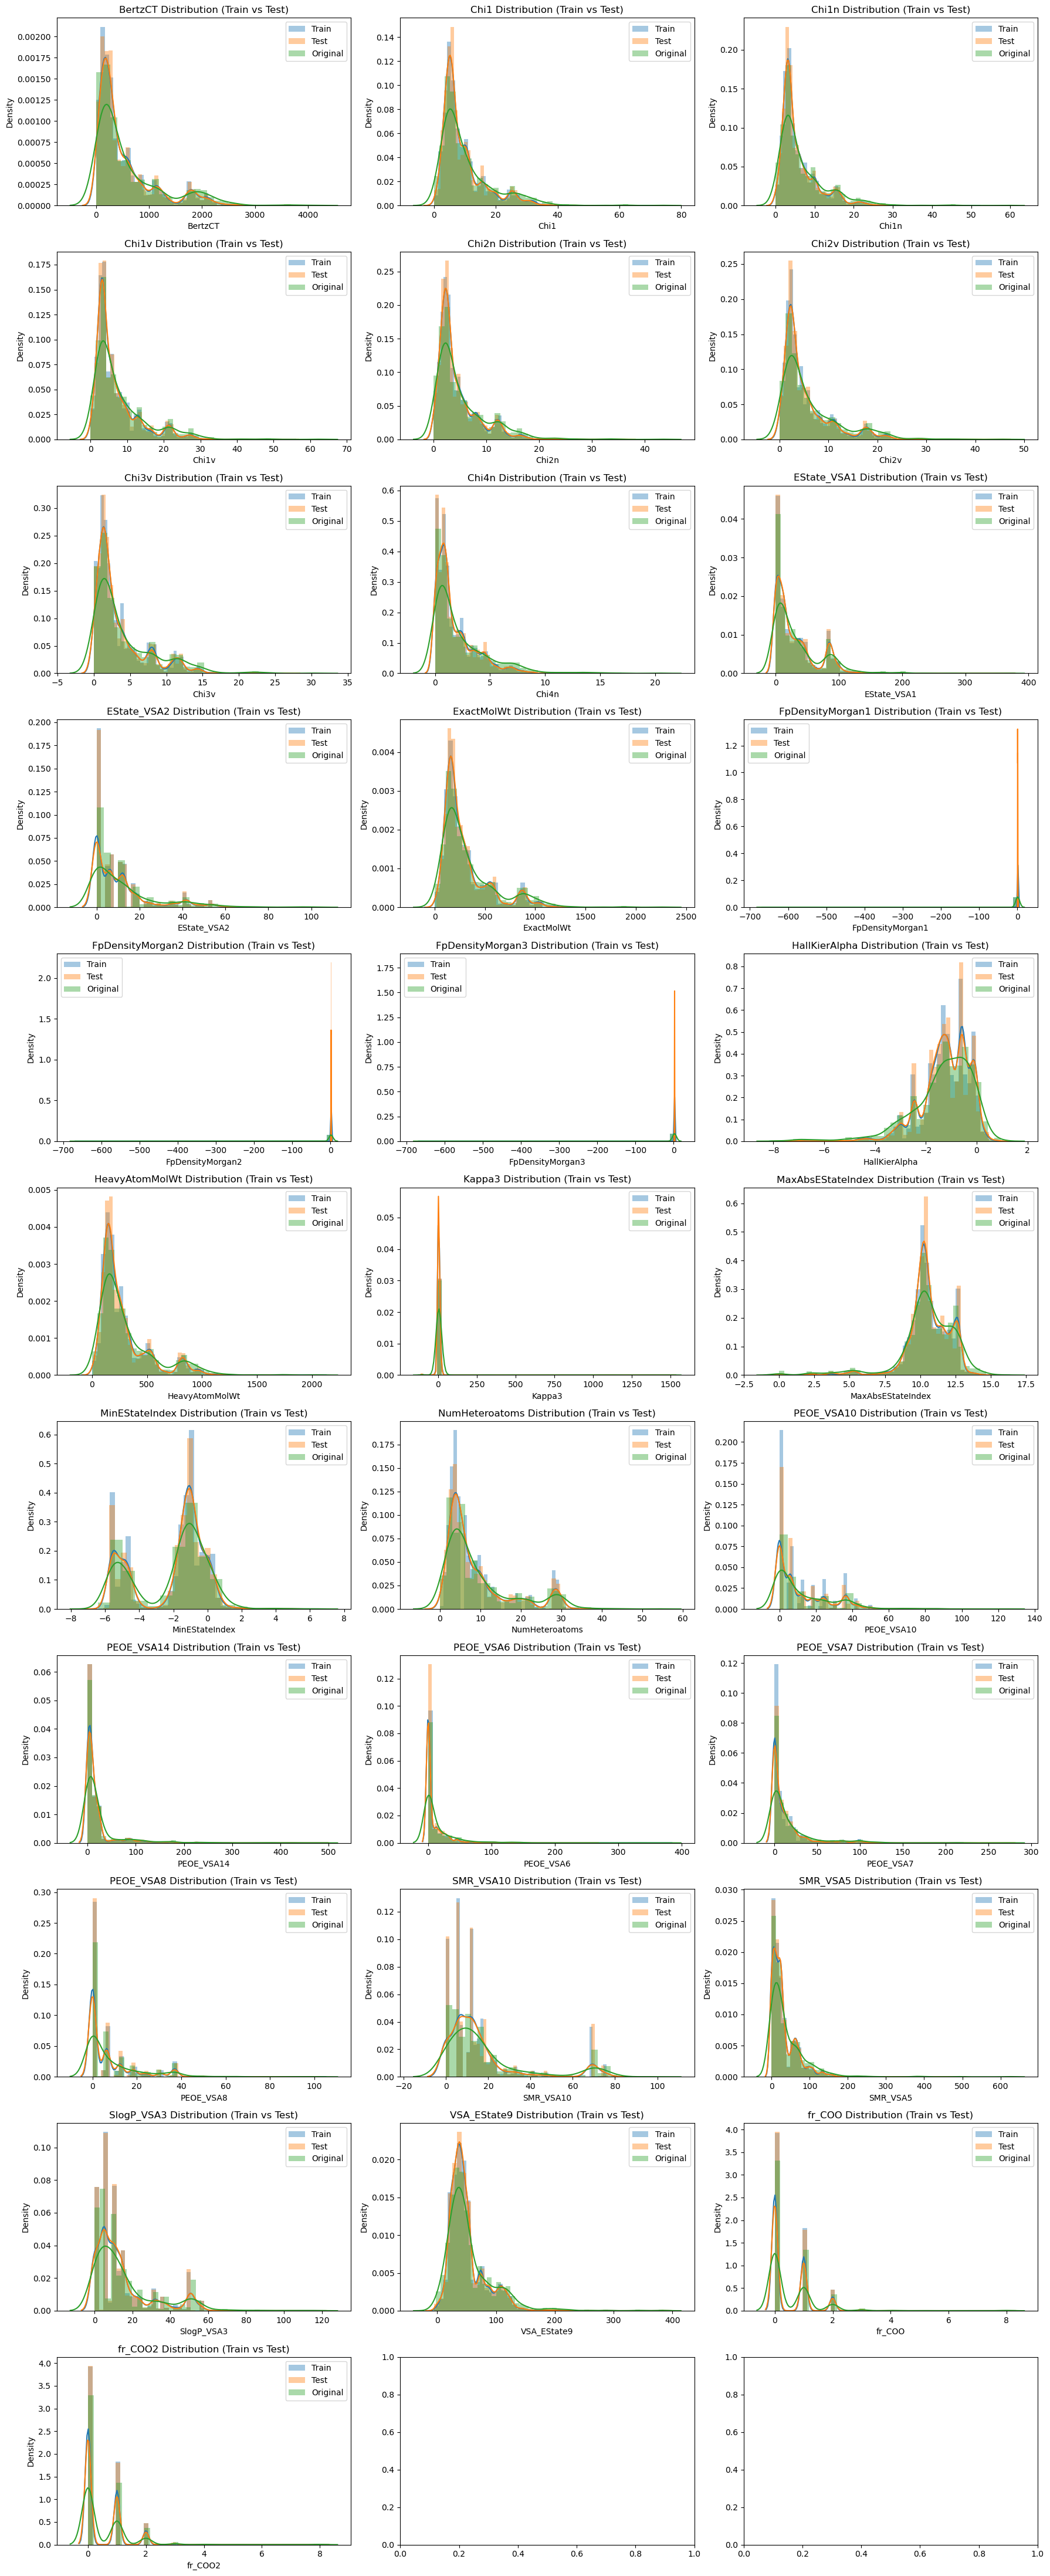

In [4]:
def plot_histograms(df_train, df_test, original, target_col, n_cols=3):
    n_rows = (len(df_train.columns) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()

    for i, var_name in enumerate(df_train.columns.tolist()):
        if var_name != 'is_generated':
            ax = axes[i]
            sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
            if var_name != target_col:
                sns.distplot(df_test[var_name], kde=True, ax=ax, label='Test')
            sns.distplot(original[var_name], kde=True, ax=ax, label='Original')
            ax.set_title(f'{var_name} Distribution (Train vs Test)')
            ax.legend()

    plt.tight_layout()
    plt.show()
        
plot_histograms(df_train[num_cols], df_test[num_cols], original[num_cols], target_cols[0], n_cols=3)

* create_features() : Create new features.
* add_decomp_features() : Add NMF results as features.
* cat_encoder() : select Label Encoder or Count Encoder or OneHot Encoder
* AggFeatureExtractor: Create Aggregate Feature
* This time, instead of multi-class classification, try to solve the problem with 2-class classification, targeting EC1 and EC2 respectively.
* Creating and predicting meta-features for EC1 and EC2 will also be verified in the near term.

In [5]:
def create_features(df):
    
    new_features = {
        'BertzCT_MaxAbsEStateIndex_Ratio': df['BertzCT'] / (df['MaxAbsEStateIndex'] + 1e-12),
        'BertzCT_ExactMolWt_Product': df['BertzCT'] * df['ExactMolWt'],
        'NumHeteroatoms_FpDensityMorgan1_Ratio': df['NumHeteroatoms'] / (df['FpDensityMorgan1'] + 1e-12),
        'VSA_EState9_EState_VSA1_Ratio': df['VSA_EState9'] / (df['EState_VSA1'] + 1e-12),
        'PEOE_VSA10_SMR_VSA5_Ratio': df['PEOE_VSA10'] / (df['SMR_VSA5'] + 1e-12),
        'Chi1v_ExactMolWt_Product': df['Chi1v'] * df['ExactMolWt'],
        'Chi2v_ExactMolWt_Product': df['Chi2v'] * df['ExactMolWt'],
        'Chi3v_ExactMolWt_Product': df['Chi3v'] * df['ExactMolWt'],
        'EState_VSA1_NumHeteroatoms_Product': df['EState_VSA1'] * df['NumHeteroatoms'],
        'PEOE_VSA10_Chi1_Ratio': df['PEOE_VSA10'] / (df['Chi1'] + 1e-12),
        'MaxAbsEStateIndex_NumHeteroatoms_Ratio': df['MaxAbsEStateIndex'] / (df['NumHeteroatoms'] + 1e-12),
        'BertzCT_Chi1_Ratio': df['BertzCT'] / (df['Chi1'] + 1e-12),
    }
    
    df = df.assign(**new_features)
    new_cols = list(new_features.keys())
    
    return df, new_cols

def add_decomp_features(X_train, X_test, n_components=5):    
    
    # Select the columns
    pca_features = X_train.select_dtypes(include=['float64']).columns.tolist()
    n_components = len(decomp_features) if n_components == 'all' else n_components

    # Create the pipeline
    pipeline = make_pipeline(MinMaxScaler(), NMF(n_components=n_components))
    
    # Perform
    pipeline.fit(X_train[decomp_features])

    # Create column names
    pca_columns = [f'NMF_{i}' for i in range(n_components)]

    # Add PCA features to the dataframe
    X_train[pca_columns] = pipeline.transform(X_train[pca_features])
    X_test[pca_columns] = pipeline.transform(X_test[pca_features])

    return X_train, X_test

class MyCategoryEncoders():
    
    def __init__(self, cat_cols, encode='label'):
        self.cat_cols = cat_cols
        self.encode = encode
        
    def cat_encoder(self, X_train, X_test):
        if self.encode == 'label':
            ## Label Encoder
            encoder = OrdinalEncoder(cols=self.cat_cols)
            train_encoder = encoder.fit_transform(X_train[self.cat_cols]).astype(int)
            test_encoder = encoder.transform(X_test[self.cat_cols]).astype(int)
            X_train[self.cat_cols] = train_encoder[self.cat_cols]
            X_test[self.cat_cols] = test_encoder[self.cat_cols]
            encoder_cols = self.cat_cols
        elif self.encode == 'count':
            ## Count Encoder
            encoder = CountEncoder(cols=self.cat_cols)
            train_encoder = encoder.fit_transform(X_train[self.cat_cols]).astype(int).add_suffix('_count')
            test_encoder = encoder.transform(X_test[self.cat_cols]).astype(int).add_suffix('_count')
            X_train = pd.concat([X_train, train_encoder], axis=1)
            X_test = pd.concat([X_test, test_encoder], axis=1)
            encoder_cols = list(train_encoder.columns)
        else:
            ## OneHot Encoder
            encoder = OneHotEncoder(handle_unknown='ignore')
            train_encoder = encoder.fit_transform(X_train[self.cat_cols]).astype(int)
            test_encoder = encoder.transform(X_test[self.cat_cols]).astype(int)
            X_train = pd.concat([X_train, train_encoder], axis=1)
            X_test = pd.concat([X_test, test_encoder], axis=1)
            X_train.drop(self.cat_cols, axis=1, inplace=True)
            X_test.drop(self.cat_cols, axis=1, inplace=True)
            encoder_cols = list(train_encoder.columns)

        return X_train, X_test, encoder_cols

class AggFeatureExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, group_col, agg_col, agg_func):
        self.group_col = group_col
        self.group_col_name = ''
        for col in group_col:
            self.group_col_name += col
        self.agg_col = agg_col
        self.agg_func = agg_func
        self.agg_df = None
        self.medians = None
        
    def fit(self, X, y=None):
        group_col = self.group_col
        agg_col = self.agg_col
        agg_func = self.agg_func
        
        self.agg_df = X.groupby(group_col)[agg_col].agg(agg_func)
        self.agg_df.columns = [f'{self.group_col_name}_{agg}_{_agg_col}' for _agg_col in agg_col for agg in agg_func]
        self.medians = X[agg_col].median()
        
        return self
    
    def transform(self, X):
        group_col = self.group_col
        agg_col = self.agg_col
        agg_func = self.agg_func
        agg_df = self.agg_df
        medians = self.medians
        
        X_merged = pd.merge(X, agg_df, left_on=group_col, right_index=True, how='left')
        X_merged.fillna(medians, inplace=True)
        X_agg = X_merged.loc[:, [f'{self.group_col_name}_{agg}_{_agg_col}' for _agg_col in agg_col for agg in agg_func]]
        
        return X_agg
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        X_agg = self.transform(X)
        return X_agg

In [7]:
y_trains = []
X_trains = []
X_tests = []

# Define Categorical Features
cat_cols = ['fr_COO'] # 'fr_COO2'
num_cols = list(set(num_cols) - set(cat_cols))

# Concatenate train and original dataframes, and prepare train and test sets
train = pd.concat([df_train, original]).drop_duplicates()
test = df_test.copy()

for target_col in target_cols:
    print(f'--{target_col}--')
    
    X_train = train.drop(binary_cols+target_cols, axis=1).reset_index(drop=True)
    y_train = train[f'{target_col}'].reset_index(drop=True).astype(int)
    X_test = test.reset_index(drop=True)
    
    # ------------------
    # Create combination Features
    # ------------------
    X_train, _ = create_features(X_train)
    X_test, _ = create_features(X_test)
    
    # ------------------
    # Create Decomposion Features
    # ------------------
    # if target_col == 'EC2':
    #     X_train, X_test = add_decomp_features(X_train, X_test)
    
    # ------------------
    # Categorical encoder
    # ------------------
    # ce = MyCategoryEncoders(cat_cols, encode='count')
    # X_train, X_test, _ = ce.cat_encoder(X_train, X_test)
    
    # ------------------
    # Aggregate Features
    # ------------------
    group_cols = [
        ['EState_VSA2'], ['HallKierAlpha'], ['NumHeteroatoms'], 
        ['PEOE_VSA10'], ['PEOE_VSA14'], ['PEOE_VSA6'], ['PEOE_VSA7'], ['PEOE_VSA8'],
        ['SMR_VSA10'], ['SMR_VSA5'], ['SlogP_VSA3'], ['fr_COO'], #['fr_COO2'],
    ]
    agg_col = [
        'BertzCT',
        'Chi1', 
        'Chi1n', 
        'Chi1v', 
        'Chi2n', 
        'Chi2v', 
        'Chi3v', 
#         'Chi4n',
        'EState_VSA1', 
        'ExactMolWt', 
        'FpDensityMorgan1', 
        'FpDensityMorgan2', 
        'FpDensityMorgan3',
        'HeavyAtomMolWt', 
#         'Kappa3', 
        'MaxAbsEStateIndex', 
        'MinEStateIndex', 
        'VSA_EState9'
    ]
    agg_train, agg_test = [], []
    for group_col in group_cols:
        agg_extractor = AggFeatureExtractor(group_col=group_col, agg_col=agg_col, agg_func=['mean', 'std'])
        agg_extractor.fit(pd.concat([X_train, X_test], axis=0))
        agg_train.append(agg_extractor.transform(X_train))
        agg_test.append(agg_extractor.transform(X_test))
    X_train = pd.concat([X_train] + agg_train, axis=1).fillna(0)
    X_test = pd.concat([X_test] + agg_test, axis=1).fillna(0)
    
    # ------------------
    # StandardScaler
    # ------------------
    # sc = StandardScaler() # MinMaxScaler or StandardScaler
    # X_train[num_cols+new_cols1+new_cols2] = sc.fit_transform(X_train[num_cols+new_cols1+new_cols2])
    # X_test[num_cols+new_cols1+new_cols2] = sc.transform(X_test[num_cols+new_cols1+new_cols2])
    
    # ------------------
    # Drop Features
    # Highly correlated 
    # ['ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2', 'fr_COO']
    # ['FpDensityMorgan2', 'FpDensityMorgan3', 'HeavyAtomMolWt', 'fr_COO2']
    # ------------------
    drop_cols = ['is_generated', 'fr_COO2']
    X_train = X_train.drop(drop_cols, axis=1) # +[drop_target_col]
    X_test = X_test.drop(drop_cols, axis=1)
    
    print(f"X_train shape :{X_train.shape} , y_train shape :{y_train.shape}")
    print(f"X_test shape :{X_test.shape}")
    print(f"X_train ->  isnull :{X_train.isnull().values.sum()}", f", isinf :{np.isinf(X_train).values.sum()}")
    print(f"X_test -> isnull :{X_test.isnull().values.sum()}", f", isinf :{np.isinf(X_train).values.sum()}")
    display(X_train.head(3))
    
    # Store Train and Test Data
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)

del train, test, df_train, df_test, agg_train, agg_test



--EC1--
X_train shape :(15841, 426) , y_train shape :(15841,)
X_test shape :(9893, 426)
X_train ->  isnull :0 , isinf :0
X_test -> isnull :0 , isinf :0


BertzCT       Chi1     Chi1n      Chi1v     Chi2n     Chi2v     Chi3v  \
0  323.390782   9.879918  5.875576   5.875576  4.304757  4.304757  2.754513   
1  273.723798   7.259037  4.441467   5.834958  3.285046  4.485235  2.201375   
2  521.643822  10.911303  8.527859  11.050864  6.665291  9.519706  5.824822   

      Chi4n  EState_VSA1  EState_VSA2  ...  fr_COO_mean_FpDensityMorgan3  \
0  1.749203     0.000000    11.938294  ...                      2.209732   
1  1.289775    45.135471     0.000000  ...                      2.209732   
2  1.770579    15.645394     6.606882  ...                      2.209732   

   fr_COO_std_FpDensityMorgan3  fr_COO_mean_HeavyAtomMolWt  \
0                     7.433743                  321.608036   
1                     7.433743                  321.608036   
2                     7.433743                  321.608036   

   fr_COO_std_HeavyAtomMolWt  fr_COO_mean_MaxAbsEStateIndex  \
0                 232.896703                      10.602613   
1                 232.896703                      10.602613   
2                 232.896703                      10.602613   

   fr_COO_std_MaxAbsEStateIndex  fr_COO_mean_MinEStateIndex  \
0                      1.872492                    -2.40764   
1                      1.872492                    -2.40764   
2                      1.872492                    -2.40764   

   fr_COO_std_MinEStateIndex  fr_COO_mean_VSA_EState9  fr_COO_std_VSA_EState9  
0                   2.374573                53.145372               32.233942  
1                   2.374573                53.145372               32.233942  
2                   2.374573                53.145372               32.233942  

[3 rows x 426 columns]

--EC2--
X_train shape :(15841, 426) , y_train shape :(15841,)
X_test shape :(9893, 426)
X_train ->  isnull :0 , isinf :0
X_test -> isnull :0 , isinf :0


BertzCT       Chi1     Chi1n      Chi1v     Chi2n     Chi2v     Chi3v  \
0  323.390782   9.879918  5.875576   5.875576  4.304757  4.304757  2.754513   
1  273.723798   7.259037  4.441467   5.834958  3.285046  4.485235  2.201375   
2  521.643822  10.911303  8.527859  11.050864  6.665291  9.519706  5.824822   

      Chi4n  EState_VSA1  EState_VSA2  ...  fr_COO_mean_FpDensityMorgan3  \
0  1.749203     0.000000    11.938294  ...                      2.209732   
1  1.289775    45.135471     0.000000  ...                      2.209732   
2  1.770579    15.645394     6.606882  ...                      2.209732   

   fr_COO_std_FpDensityMorgan3  fr_COO_mean_HeavyAtomMolWt  \
0                     7.433743                  321.608036   
1                     7.433743                  321.608036   
2                     7.433743                  321.608036   

   fr_COO_std_HeavyAtomMolWt  fr_COO_mean_MaxAbsEStateIndex  \
0                 232.896703                      10.602613   
1                 232.896703                      10.602613   
2                 232.896703                      10.602613   

   fr_COO_std_MaxAbsEStateIndex  fr_COO_mean_MinEStateIndex  \
0                      1.872492                    -2.40764   
1                      1.872492                    -2.40764   
2                      1.872492                    -2.40764   

   fr_COO_std_MinEStateIndex  fr_COO_mean_VSA_EState9  fr_COO_std_VSA_EState9  
0                   2.374573                53.145372               32.233942  
1                   2.374573                53.145372               32.233942  
2                   2.374573                53.145372               32.233942  

[3 rows x 426 columns]

Data Splitting

In [8]:
class Splitter:
    def __init__(self, kfold=True, n_splits=5, cat_df=pd.DataFrame(), test_size=0.5):
        self.n_splits = n_splits
        self.kfold = kfold
        self.cat_df = cat_df
        self.test_size = test_size

    def split_data(self, X, y, random_state_list):
        if self.kfold == 'skf':
            for random_state in random_state_list:
                kf = StratifiedKFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, self.cat_df):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val, val_index
        elif self.kfold:
            for random_state in random_state_list:
                kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val, val_index
        else:
            for random_state in random_state_list:
                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=random_state)
                yield X_train, X_val, y_train, y_val

Define Model

LightGBM, CatBoost Xgboost and HistGradientBoosting hyper parameters are determined by optuna.

In [9]:
class Classifier:
    def __init__(self, target_col, n_estimators=100, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model(target_col)
        self.models_name = list(self._define_model(target_col).keys())
        self.len_models = len(self.models)
        
    def _define_model(self, target_col):
        
        if target_col == 'EC1':
            xgb1_params = {
                'n_estimators': self.n_estimators,
                'learning_rate': 0.00764887595631511,
                'booster': 'gbtree',
                'lambda': 0.0379675844718388,
                'alpha': 0.0127846822376181,
                'subsample': 0.954836600053134,
                'colsample_bytree': 0.303279712350842,
                'max_depth': 9,
                'min_child_weight': 8,
                'eta': 7.78550117314348E-07,
                'gamma': 2.16524511622072E-06,
                'grow_policy': 'lossguide',
                'n_jobs': -1,
                'objective': 'binary:logistic',
                'eval_metric': 'auc',
                'verbosity': 0,
                'random_state': self.random_state,
            }
            xgb2_params = {
                'n_estimators': self.n_estimators,
                'learning_rate': 0.00610113589892878,
                'booster': 'gbtree',
                'lambda': 8.96906460616343E-08,
                'alpha': 0.179699301214927,
                'subsample': 0.693147524348261,
                'colsample_bytree': 0.201796295242956,
                'max_depth': 7,
                'min_child_weight': 7,
                'eta': 0.491486337405877,
                'gamma': 0.0219744528297816,
                'grow_policy': 'lossguide',
                'n_jobs': -1,
                'objective': 'binary:logistic',
                'eval_metric': 'auc',
                'verbosity': 0,
                'random_state': self.random_state,
            }
        elif target_col == 'EC2':
            xgb1_params = {
                'n_estimators': self.n_estimators,
                'learning_rate': 0.0258060514910791,
                'booster': 'gbtree',
                'lambda': 7.46721185757775E-06,
                'alpha': 2.76013165565544E-08,
                'subsample': 0.20132629296478,
                'colsample_bytree': 0.45781987213833,
                'max_depth': 5,
                'min_child_weight': 5,
                'eta': 3.9844926835765E-07,
                'gamma': 0.0000620888806796158,
                'grow_policy': 'depthwise',
                'n_jobs': -1,
                'objective': 'binary:logistic',
                'eval_metric': 'auc',
                'verbosity': 0,
                'random_state': self.random_state,
            }
            xgb2_params = {
                'n_estimators': self.n_estimators,
                'learning_rate': 0.03045801481188,
                'booster': 'gbtree',
                'lambda': 0.141226751984267,
                'alpha': 0.0000169212384166775,
                'subsample': 0.354547691277393,
                'colsample_bytree': 0.741230587323123,
                'max_depth': 3,
                'min_child_weight': 8,
                'eta': 0.000200365560443557,
                'gamma': 0.000793115073634548,
                'grow_policy': 'depthwise',
                'n_jobs': -1,
                'objective': 'binary:logistic',
                'eval_metric': 'auc',
                'verbosity': 0,
                'random_state': self.random_state,
            }
        if self.device == 'gpu':
            xgb1_params['tree_method'] = 'gpu_hist'
            xgb1_params['predictor'] = 'gpu_predictor'
            xgb2_params['tree_method'] = 'gpu_hist'
            xgb2_params['predictor'] = 'gpu_predictor'
        
        if target_col == 'EC1':
            lgb1_params = {
                'n_estimators': self.n_estimators,
                'learning_rate': 0.0228011747280739,
                'reg_alpha': 5.65344226754958E-08,
                'reg_lambda': 0.0000457329103646115,
                'num_leaves': 41,
                'colsample_bytree': 0.44294848432797,
                'subsample': 0.751451025433351,
                'subsample_freq': 4,
                'min_child_samples': 47,
                'objective': 'binary',
                'metric': 'auc', # binary_error
                'boosting_type': 'gbdt',
                #'is_unbalance':True,
                # 'n_jobs': -1,
                #'force_row_wise': True,
                'device': self.device,
                'random_state': self.random_state
            }
            lgb2_params = {
                'n_estimators': self.n_estimators,
                'learning_rate': 0.0150317388979459,
                'reg_alpha': 0.000137387220669803,
                'reg_lambda': 0.0465956586731766,
                'num_leaves': 122,
                'colsample_bytree': 0.577212162074888,
                'subsample': 0.414797294649733,
                'subsample_freq': 2,
                'min_child_samples': 89,
                'objective': 'binary',
                'metric': 'auc', # binary_error
                'boosting_type': 'gbdt',
                #'is_unbalance':True,
                # 'n_jobs': -1,
                #'force_row_wise': True,
                'device': self.device,
                'random_state': self.random_state
            }
        elif target_col == 'EC2':
            lgb1_params = {
                'n_estimators': self.n_estimators,
                'learning_rate': 0.00235571575065482,
                'reg_alpha': 0.0000155412959959893,
                'reg_lambda': 0.0000347193406478947,
                'num_leaves': 131,
                'colsample_bytree': 0.468735996560667,
                'subsample': 0.428043349939151,
                'subsample_freq': 7,
                'min_child_samples': 14,
                'objective': 'binary',
                'metric': 'auc', # binary_error
                'boosting_type': 'gbdt',
                #'is_unbalance':True,
                # 'n_jobs': -1,
                #'force_row_wise': True,
                'device': self.device,
                'random_state': self.random_state
            }
            lgb2_params = {
                'n_estimators': self.n_estimators,
                'learning_rate': 0.0342188703436379,
                'reg_alpha': 2.39175347967819,
                'reg_lambda': 0.139145028543823,
                'num_leaves': 22,
                'colsample_bytree': 0.607700187719924,
                'subsample': 0.608258988150217,
                'subsample_freq': 2,
                'min_child_samples': 35,
                'objective': 'binary',
                'metric': 'auc', # binary_error
                'boosting_type': 'gbdt',
                #'is_unbalance':True,
                # 'n_jobs': -1,
                #'force_row_wise': True,
                'device': self.device,
                'random_state': self.random_state
            }
        if target_col == 'EC1':
            cat1_params = {
                'iterations': self.n_estimators,
                'depth': 3,
                'learning_rate': 0.020258010893459,
                'l2_leaf_reg': 0.583685138705941,
                'random_strength': 0.177768021213223,
                'od_type': "Iter", 
                'od_wait': 116,
                'bootstrap_type': "Bayesian",
                'grow_policy': 'Depthwise',
                'bagging_temperature': 0.478048798393903,
                'eval_metric': 'AUC', # AUC
                'loss_function': 'Logloss',
                #'auto_class_weights': 'Balanced',
                'task_type': self.device.upper(),
                'verbose': False,
                'allow_writing_files': False,
                'random_state': self.random_state
            }
            cat2_params = {
                'iterations': self.n_estimators,
                'depth': 4,
                'learning_rate': 0.0533074594005429,
                'l2_leaf_reg': 4.33121673696473,
                'random_strength': 0.00420305570017096,
                'od_type': "IncToDec", 
                'od_wait': 41,
                'bootstrap_type': "Bayesian",
                'grow_policy': 'Lossguide',
                'bagging_temperature': 9.20357081888618,
                'eval_metric': 'AUC', # AUC
                'loss_function': 'Logloss',
                #'auto_class_weights': 'Balanced',
                'task_type': self.device.upper(),
                'verbose': False,
                'allow_writing_files': False,
                'random_state': self.random_state
            }
        elif target_col == 'EC2':
            cat1_params = {
                'iterations': self.n_estimators,
                'depth': 4,
                'learning_rate': 0.0533074594005429,
                'l2_leaf_reg': 4.33121673696473,
                'random_strength': 0.00420305570017096,
                'od_type': "IncToDec", 
                'od_wait': 41,
                'bootstrap_type': "Bayesian",
                'grow_policy': 'Lossguide',
                'bagging_temperature': 9.20357081888618,
                'eval_metric': 'AUC', # AUC
                'loss_function': 'Logloss',
                #'auto_class_weights': 'Balanced',
                'task_type': self.device.upper(),
                'verbose': False,
                'allow_writing_files': False,
                'random_state': self.random_state
            }
            cat2_params = {
                'iterations': self.n_estimators,
                'depth': 5,
                'learning_rate': 0.0991887029880458,
                'l2_leaf_reg': 3.42589726767107,
                'random_strength': 0.143663354460193,
                'od_type': "Iter", 
                'od_wait': 134,
                'bootstrap_type': "Bayesian",
                'grow_policy': 'Lossguide',
                'bagging_temperature': 9.03599121747771,
                'eval_metric': 'AUC', # AUC
                'loss_function': 'Logloss',
                #'auto_class_weights': 'Balanced',
                'task_type': self.device.upper(),
                'verbose': False,
                'allow_writing_files': False,
                'random_state': self.random_state
            }
        
        if target_col == 'EC1':
            hist_params = {
                'l2_regularization': 0.654926989031482,
                'learning_rate': 0.0366207257406611,
                'max_iter': self.n_estimators,
                'max_depth': 30,
                'max_bins': 255,
                'min_samples_leaf': 52,
                'max_leaf_nodes':12,
                'early_stopping': True,
                'n_iter_no_change': 50,
                'categorical_features': cat_cols,
                #'class_weight':'balanced',
                'random_state': self.random_state
            }
        elif target_col == 'EC2':
            hist_params = {
                'l2_regularization': 0.0769190915635041,
                'learning_rate': 0.0560046631920058,
                'max_iter': self.n_estimators,
                'max_depth': 30,
                'max_bins': 255,
                'min_samples_leaf': 30,
                'max_leaf_nodes':10,
                'early_stopping': True,
                'n_iter_no_change': 50,
                'categorical_features': cat_cols,
                #'class_weight':'balanced',
                'random_state': self.random_state
            }
                    
        mlp_params = {
            'max_iter': 800,
            'early_stopping': True,
            'n_iter_no_change': 50,
            'random_state': self.random_state,
        }
        
        if target_col == 'EC1':
            models = {
                "xgb": xgb.XGBClassifier(**xgb1_params),
                "lgb": lgb.LGBMClassifier(**lgb1_params),
                "cat": CatBoostClassifier(**cat1_params),
#                 "xgb2": xgb.XGBClassifier(**xgb2_params),
                "lgb2": lgb.LGBMClassifier(**lgb2_params),
#                 "cat2": CatBoostClassifier(**cat2_params),
                'hgb': HistGradientBoostingClassifier(**hist_params),
                'rfc': RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=self.random_state),
                'lrc': make_pipeline(StandardScaler(), LogisticRegression(max_iter=500, random_state=self.random_state)),
#                 'etc': ExtraTreesClassifier(n_estimators=800, n_jobs=-1, random_state=self.random_state),
                'mlp': make_pipeline(StandardScaler(), MLPClassifier(**mlp_params, hidden_layer_sizes=(100,))),
                'ada': AdaBoostClassifier(n_estimators=100, random_state=self.random_state)
                #'knn': KNeighborsClassifier(n_neighbors=15, n_jobs=-1),
                #'gbc': GradientBoostingClassifier(n_estimators=500, random_state=self.random_state)
                #'svc': SVC(max_iter=-1, kernel="rbf", gamma="auto", probability=True, random_state=self.random_state),
            }
        elif target_col == 'EC2':
            models = {
                "xgb": xgb.XGBClassifier(**xgb1_params),
                "lgb": lgb.LGBMClassifier(**lgb1_params),
                "cat": CatBoostClassifier(**cat1_params),
                "xgb2": xgb.XGBClassifier(**xgb2_params),
                "lgb2": lgb.LGBMClassifier(**lgb2_params),
                "cat2": CatBoostClassifier(**cat2_params),
                'hgb': HistGradientBoostingClassifier(**hist_params),
                'rfc': RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=self.random_state),
                'lrc': make_pipeline(StandardScaler(), LogisticRegression(max_iter=500, random_state=self.random_state)),
                'etc': ExtraTreesClassifier(n_estimators=800, n_jobs=-1, random_state=self.random_state),
                'mlp': make_pipeline(StandardScaler(), MLPClassifier(**mlp_params, hidden_layer_sizes=(100,))),
                'ada': AdaBoostClassifier(n_estimators=100, random_state=self.random_state)
                #'knn': KNeighborsClassifier(n_neighbors=15, n_jobs=-1),
                #'gbc': GradientBoostingClassifier(n_estimators=500, random_state=self.random_state)
                #'svc': SVC(max_iter=-1, kernel="rbf", gamma="auto", probability=True, random_state=self.random_state),
            }
        
        return models

RFE

RFECV is a technique for automated feature selection that combines recursive feature elimination and cross-validation to identify the optimal subset of features for a given machine learning task.




In [10]:
def plot_recursive_feature_elimination(elimination, scoring, min_features_to_select, name):
    n_scores = len(elimination.cv_results_["mean_test_score"])
    plt.figure(figsize=(10, 4))
    plt.xlabel("Number of features selected")
    plt.ylabel(f"{scoring}")

    # Plot the mean test scores with error bars
    plt.errorbar(
        range(min_features_to_select, n_scores + min_features_to_select),
        elimination.cv_results_["mean_test_score"],
        yerr=elimination.cv_results_["std_test_score"],
        fmt='o-',
        capsize=3,
        markersize=4,
    )

    plt.title(f"{name} Recursive Feature Elimination with correlated features", fontweight='bold')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

--EC1--
xgb  Best Mean roc_auc 0.71553 ± 0.00474 | N_STEP 0
Best unnecessary_feature: ['PEOE_VSA6_std_Chi2n', 'PEOE_VSA6_mean_Chi2v', 'PEOE_VSA6_std_MinEStateIndex', 'fr_COO_mean_VSA_EState9', 'fr_COO_std_VSA_EState9']
Removed features: ['fr_COO_std_VSA_EState9', 'PEOE_VSA6_mean_Chi2v', 'PEOE_VSA6_std_Chi2n', 'fr_COO_mean_VSA_EState9', 'PEOE_VSA6_std_MinEStateIndex']
------------------------------------------------------------
lgb  Best Mean roc_auc 0.71759 ± 0.00502 | N_STEP 1
Best unnecessary_feature: ['PEOE_VSA6_std_Chi2n', 'PEOE_VSA6_mean_Chi2v', 'fr_COO_mean_VSA_EState9', 'fr_COO_std_VSA_EState9']
Removed features: ['fr_COO_std_VSA_EState9', 'PEOE_VSA6_mean_Chi2v', 'PEOE_VSA6_std_Chi2n', 'fr_COO_mean_VSA_EState9']
------------------------------------------------------------
cat  Best Mean roc_auc 0.71597 ± 0.00731 | N_STEP 3
Best unnecessary_feature: ['BertzCT', 'PEOE_VSA6_mean_Chi2v']
Removed features: ['PEOE_VSA6_mean_Chi2v', 'BertzCT']
------------------------------------------

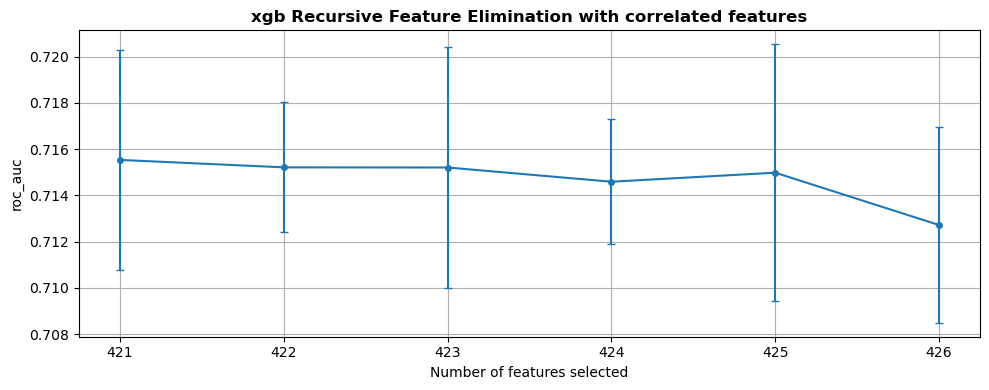

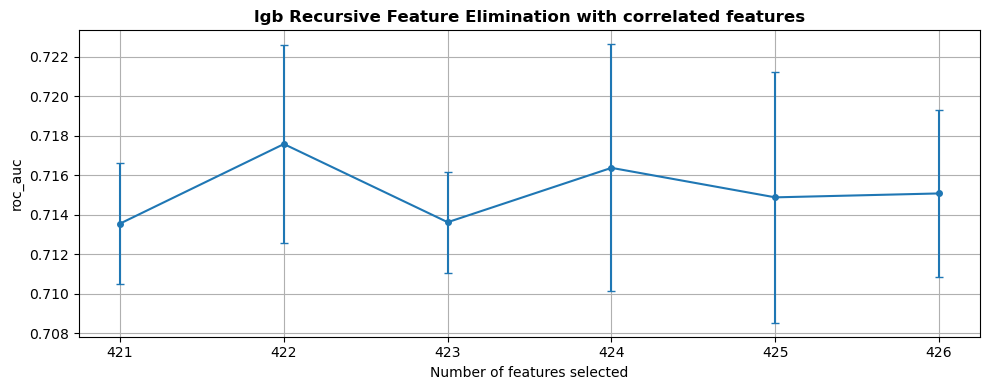

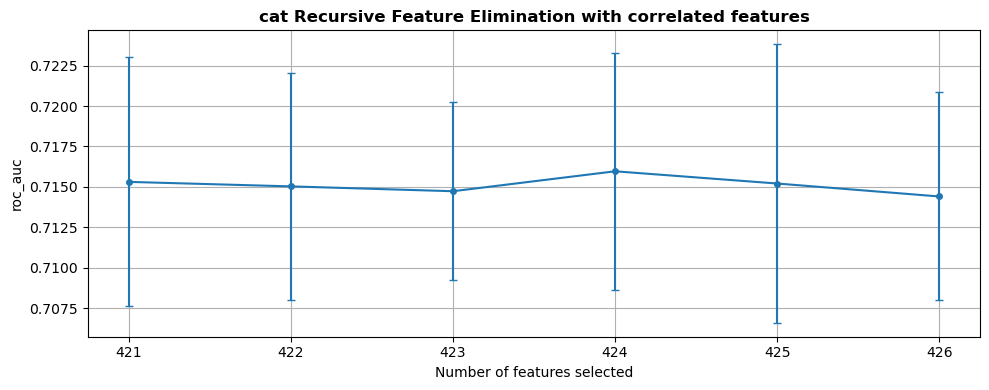

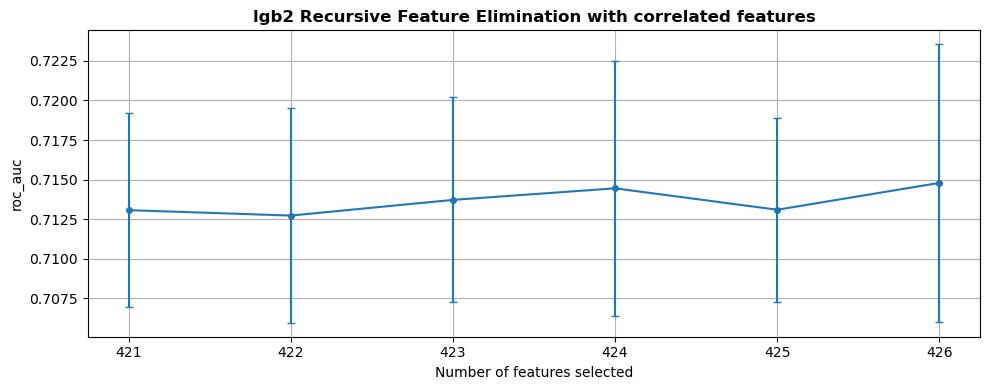

--EC2--
xgb  Best Mean roc_auc 0.55879 ± 0.00482 | N_STEP 1
Best unnecessary_feature: ['PEOE_VSA6_std_Chi2n', 'PEOE_VSA6_mean_Chi2v', 'PEOE_VSA6_std_Chi2v', 'fr_COO_std_VSA_EState9']
Removed features: ['PEOE_VSA6_mean_Chi2v', 'PEOE_VSA6_std_Chi2v', 'fr_COO_std_VSA_EState9', 'PEOE_VSA6_std_Chi2n']
------------------------------------------------------------
lgb  Best Mean roc_auc 0.56366 ± 0.01024 | N_STEP 2
Best unnecessary_feature: ['PEOE_VSA6_mean_Chi2v', 'fr_COO_mean_VSA_EState9', 'fr_COO_std_VSA_EState9']
Removed features: ['PEOE_VSA6_mean_Chi2v', 'fr_COO_std_VSA_EState9', 'fr_COO_mean_VSA_EState9']
------------------------------------------------------------
cat  Best Mean roc_auc 0.56711 ± 0.01462 | N_STEP 3
Best unnecessary_feature: ['fr_COO_mean_VSA_EState9', 'fr_COO_std_VSA_EState9']
Removed features: ['fr_COO_std_VSA_EState9', 'fr_COO_mean_VSA_EState9']
------------------------------------------------------------
xgb2  Best Mean roc_auc 0.56701 ± 0.00746 | N_STEP 4
Best unnec

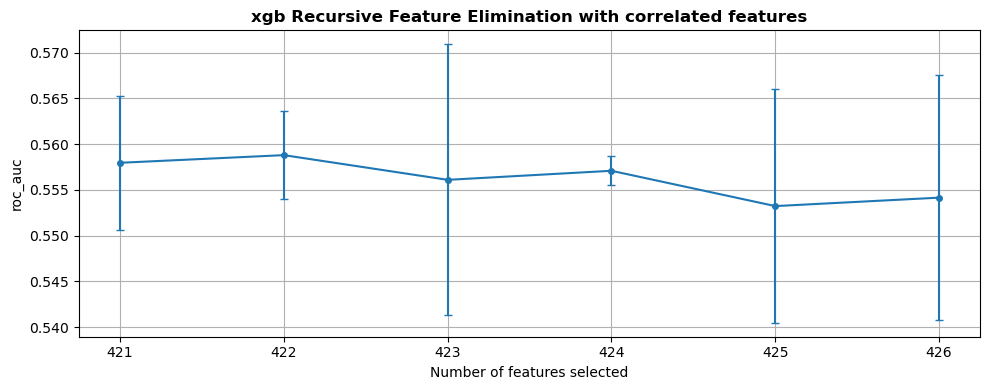

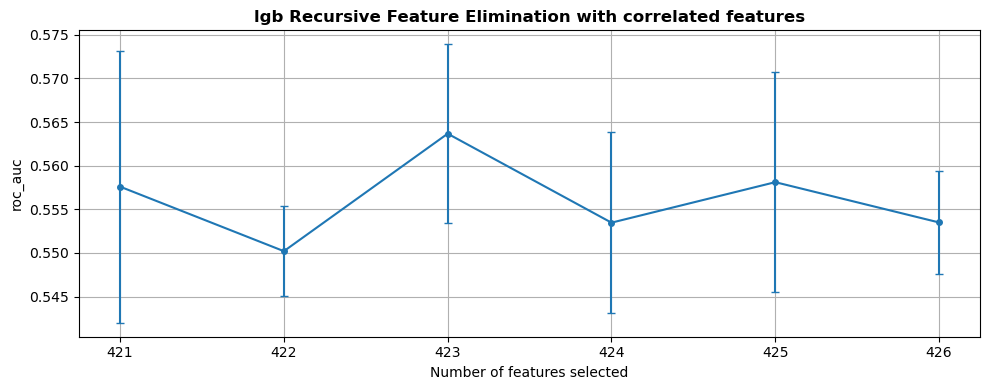

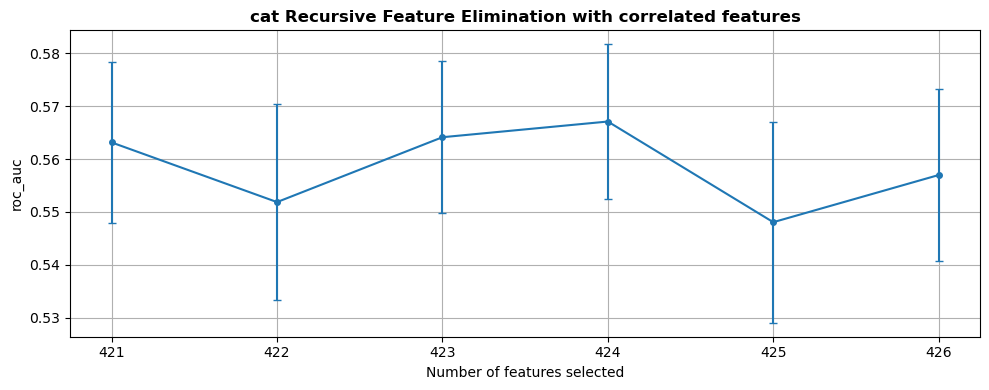

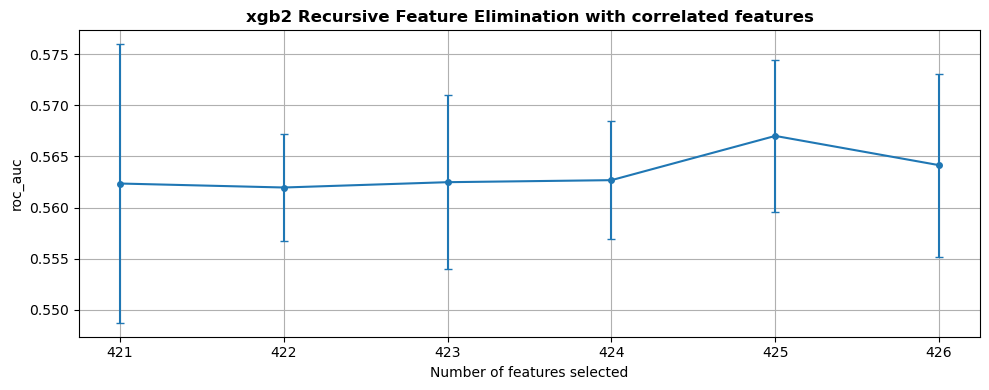

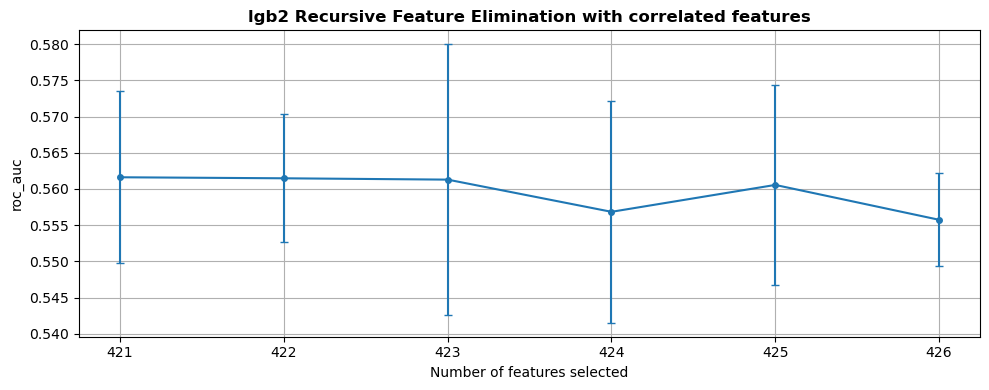

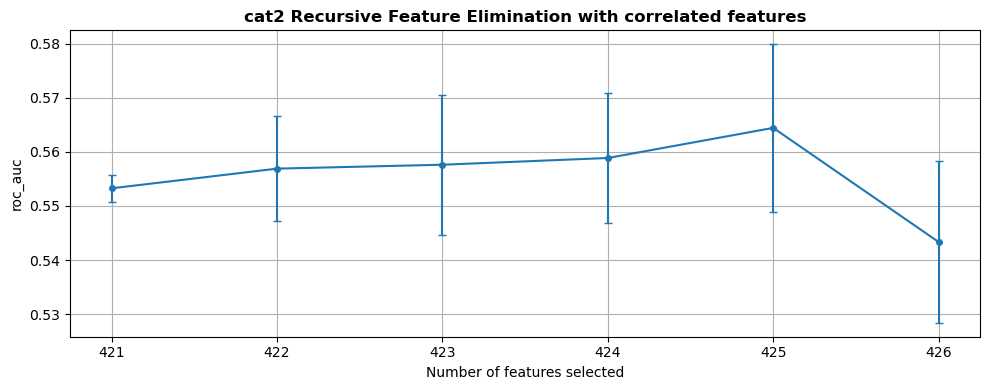

CPU times: user 2min 38s, sys: 5.06 s, total: 2min 43s
Wall time: 5min 6s


In [11]:
%%time

n_estimators = 50
scoring = 'roc_auc'

for target_col, X_train, y_train, X_test in zip(target_cols, X_trains, y_trains, X_tests):
    min_features_to_select = len(X_train.columns) - 5
    
    print(f'--{target_col}--')
    # drop_target_col = 'EC2' if target_col == 'EC1' else 'EC1'
    # X_train = X_train.drop(drop_target_col, axis=1)
    
    splitter = Splitter(kfold=False, test_size=0.7)
    X_train_, X_val, y_train_, y_val = next(iter(splitter.split_data(X_train, y_train, random_state_list=[42])))
    
    classifier = Classifier(target_col, n_estimators, device='cpu', random_state=0)
    models = classifier.models

    models_name = [_ for _ in classifier.models_name if ('xgb' in _) or ('lgb' in _) or ('cat' in _)]
    trained_models = dict(zip(models_name, ['' for _ in range(classifier.len_models)]))
    unnecessary_features = dict(zip(models_name, [[] for _ in range(classifier.len_models)]))
    for name, model in models.items():
        if ('xgb' in name) or ('lgb' in name) or ('cat' in name):
            elimination = RFECV(
                model, 
                step=1,
                min_features_to_select=min_features_to_select,
                cv=3,
                scoring=scoring, 
                n_jobs=-1)
            elimination.fit(X_train_, y_train_)
            unnecessary_feature = list(X_train.columns[~elimination.get_support()])
            idx = np.argmax(elimination.cv_results_['mean_test_score'])
            mean_score = elimination.cv_results_['mean_test_score'][idx]
            std_score = elimination.cv_results_['std_test_score'][idx]
            print(f'{blu}{name}{res} {red} Best Mean{res} {scoring} {red}{mean_score:.5f} ± {std_score:.5f}{res} | N_STEP {idx}')
            print(f"Best unnecessary_feature: {unnecessary_feature}")
            removed_features = [f for i, f in enumerate(X_train.columns) if elimination.support_[i] == False]
            ranked_features = sorted(zip(X_train.columns, elimination.ranking_), key=lambda x: x[1])
            removed_features_by_ranking = [f[0] for f in ranked_features if f[0] in removed_features][::-1]
            print("Removed features:", removed_features_by_ranking)
            print(f'{"-" * 60}')

            trained_models[f'{name}'] = deepcopy(elimination)
            unnecessary_features[f'{name}'].extend(unnecessary_feature)

    unnecessary_features = np.concatenate([_ for _ in unnecessary_features.values()])
    features = np.unique(unnecessary_features, return_counts=True)[0]
    counts = np.unique(unnecessary_features, return_counts=True)[1]
    drop_features = list(features[counts >= 2])
    print("Features recommended to be removed:", drop_features)
    
    for name, elimination in trained_models.items():
        plot_recursive_feature_elimination(elimination, scoring, min_features_to_select, name)


Configuration

In [12]:
# Settings
kfold = 'skf'
n_splits = 5 # 10
n_reapts = 3 # 1
random_state = 42
n_estimators = 9999 # 9999
early_stopping_rounds = 200
n_trials = 1000 # 3000
verbose = False
device = 'cpu'

# Fix seed
random.seed(random_state)
random_state_list = random.sample(range(9999), n_reapts)
# random_state_list = [42]
# n_reapts = len(random_state_list)

# metrics
def auc(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)
metric = auc
metric_name = metric.__name__.upper()

# To calculate runtime
def sec_to_minsec(t):
    min_ = int(t / 60)
    sec = int(t - min_*60)
    return min_, sec

# Process

Our model Xgboost

In [13]:
def plot_training_process(lossfunc_key, eval_results_, best_iters_, early_stopping_rounds):

    metric_score_folds = pd.DataFrame.from_dict(eval_results_).T
    fit_rmsle = metric_score_folds.fit.apply(lambda x: x[lossfunc_key])
    val_rmsle = metric_score_folds.val.apply(lambda x: x[lossfunc_key])

    n_splits = len(metric_score_folds)
    n_rows = math.ceil(n_splits / 3)

    fig, axes = plt.subplots(n_rows, 3, figsize=(20, n_rows * 4), dpi=150)
    ax = axes.flatten()

    for i, (f, v, best_iter) in enumerate(zip(fit_rmsle, val_rmsle, best_iters_)): 
        sns.lineplot(f, color='#B90000', ax=ax[i], label='fit')
        sns.lineplot(v, color='#048BA8', ax=ax[i], label='val')
        ax[i].legend()
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_title(f'Fold {i}', fontdict={'fontweight': 'bold'})

        color = ['#048BA8', '#90A6B1']
        span_range = [[0, best_iter], [best_iter + 10, best_iter + early_stopping_rounds]]

        for idx, sub_title in enumerate([f'Best\nIteration: {best_iter}', f'Early\n Stopping: {early_stopping_rounds}']):
            ax[i].annotate(sub_title,
                           xy=(sum(span_range[idx]) / 2, 4000),
                           xytext=(0, 0),
                           textcoords='offset points',
                           va="center",
                           ha="center",
                           color="w",
                           fontsize=12,
                           fontweight='bold',
                           bbox=dict(boxstyle='round4', pad=0.4, color=color[idx], alpha=0.6))
            ax[i].axvspan(span_range[idx][0] - 0.4, span_range[idx][1] + 0.4, color=color[idx], alpha=0.07)

        ax[i].set_xlim(0, best_iter + 20 + early_stopping_rounds)
        ax[i].set_xlabel('Boosting Round', fontsize=12)
        ax[i].set_ylabel(f'{lossfunc_key}', fontsize=12)
        ax[i].legend(loc='upper right', title=lossfunc_key)

    for j in range(i+1, n_rows * 3):
        ax[j].axis('off')

    plt.tight_layout()
    plt.show()
    

def plot_feature_importance(fi):
    fi_gain = fi[[col for col in fi.columns if col.startswith('gain')]].mean(axis=1)
    fi_splt = fi[[col for col in fi.columns if col.startswith('split')]].mean(axis=1)
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 6), dpi=150)

    # Split fi.
    data_splt = fi_splt.sort_values(ascending=False)
    data_splt = data_splt.head(20)
    sns.barplot(x=data_splt.values, y=data_splt.index,
                color='#1E90FF', linewidth=0.5, edgecolor="black", ax=ax[0])
    ax[0].set_title(f'Feature Importance "Split"', fontdict={'fontweight': 'bold'})
    ax[0].set_xlabel("Importance", fontsize=12)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)

    # Gain fi.
    data_gain = fi_gain.sort_values(ascending=False)
    data_gain = data_gain.head(20)
    sns.barplot(x=data_gain.values, y=data_gain.index,
                color='#4169E1', linewidth=0.5, edgecolor="black", ax=ax[1])
    ax[1].set_title(f'Feature Importance "Gain"', fontdict={'fontweight': 'bold'})
    ax[1].set_xlabel("Importance", fontsize=12)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)

    plt.tight_layout()
    plt.show()


--EC1--
Fold:   0| AUC: 0.70323 | Best iteration:   48
Fold:   1| AUC: 0.71987 | Best iteration:  243
Fold:   2| AUC: 0.71485 | Best iteration:  323
Fold:   3| AUC: 0.71226 | Best iteration:  195
Fold:   4| AUC: 0.71304 | Best iteration:   85
**************************************************
Mean full AUC : 0.69608
Mean val AUC  : 0.71265


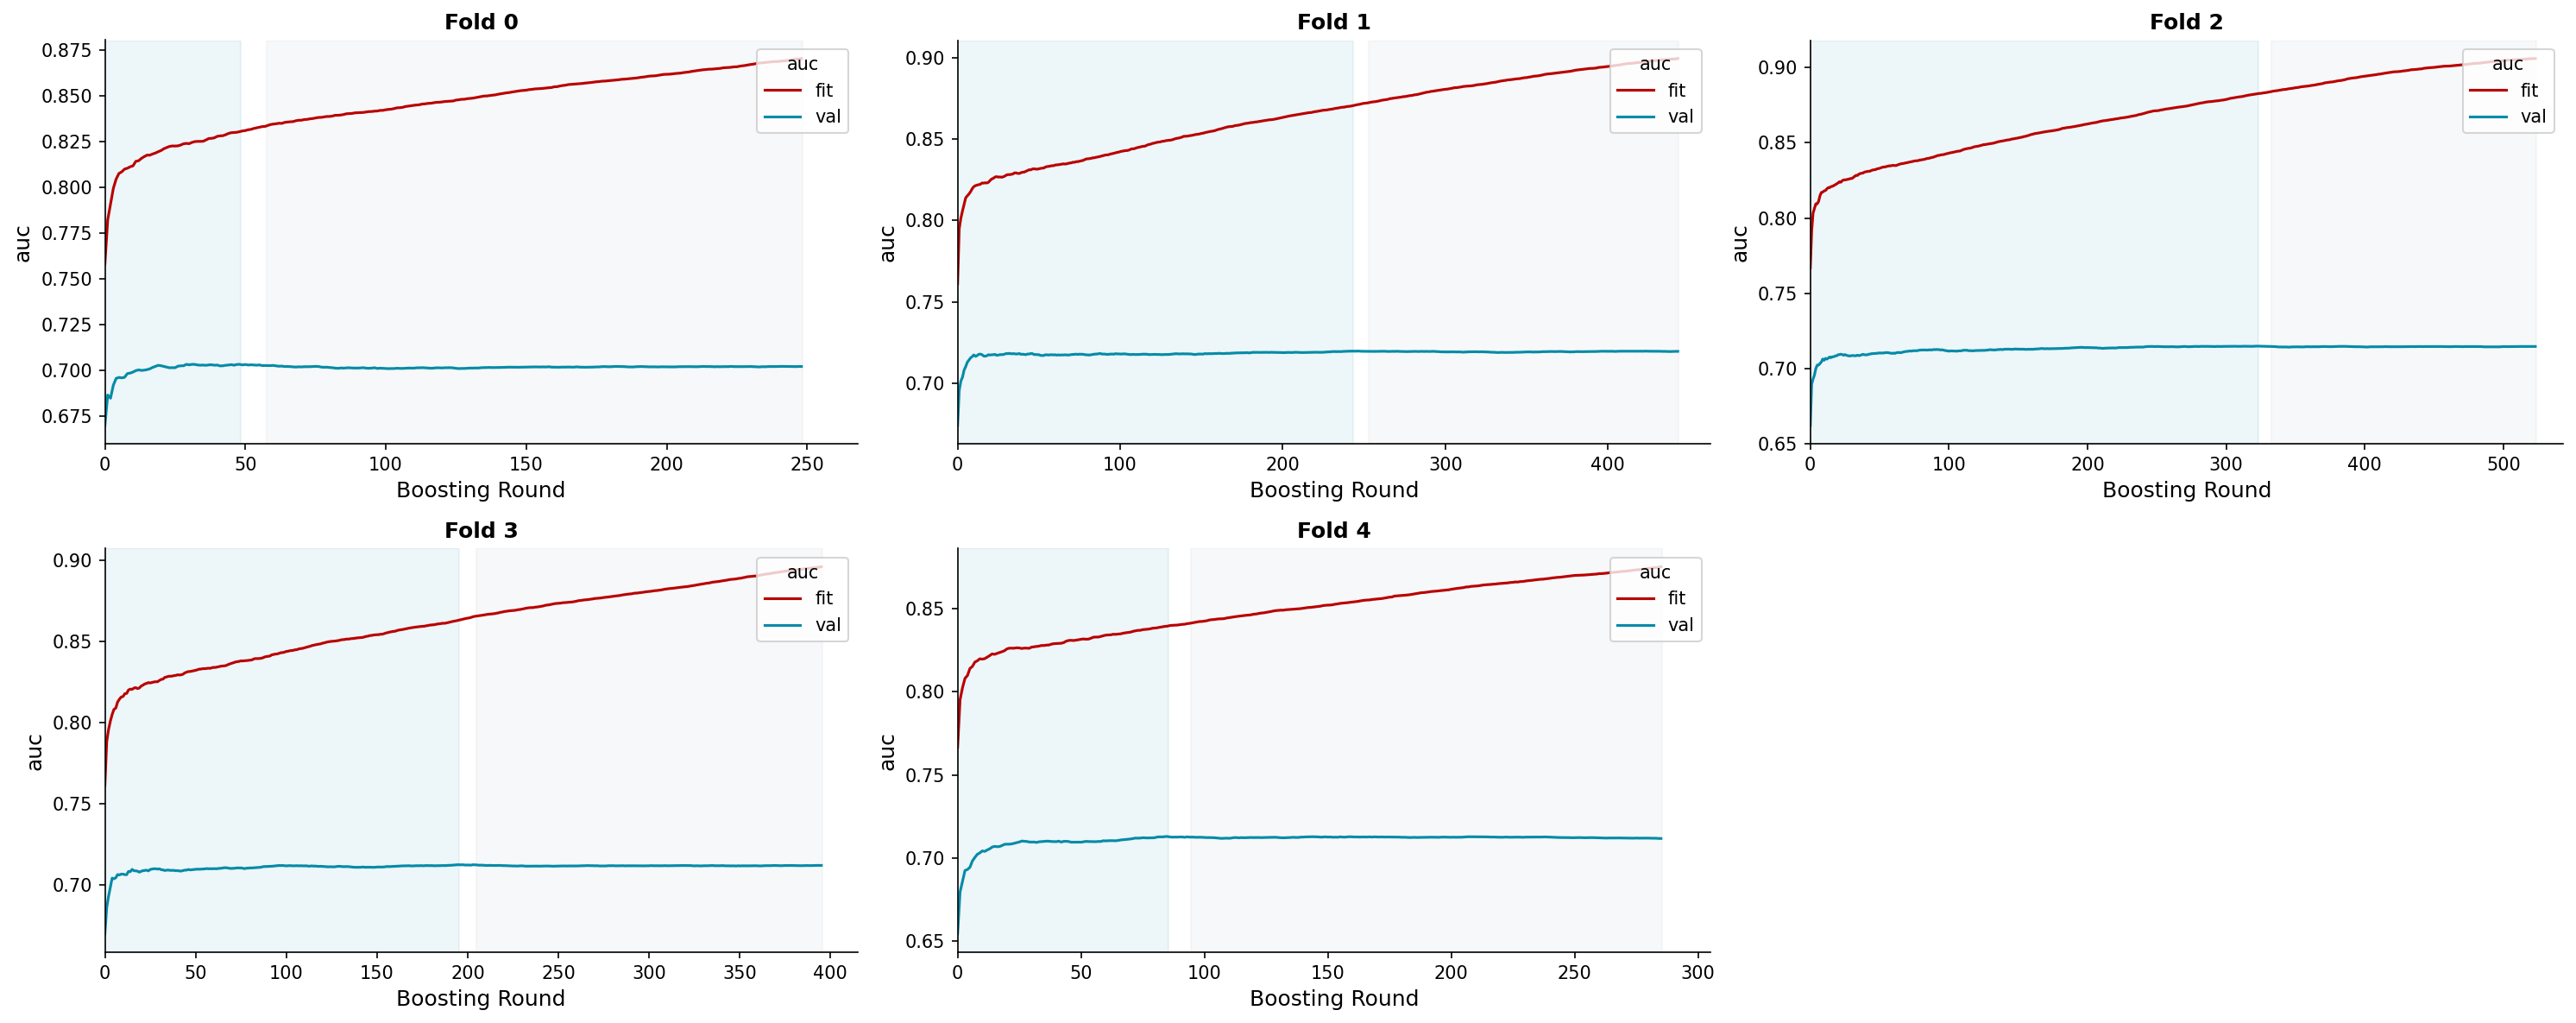

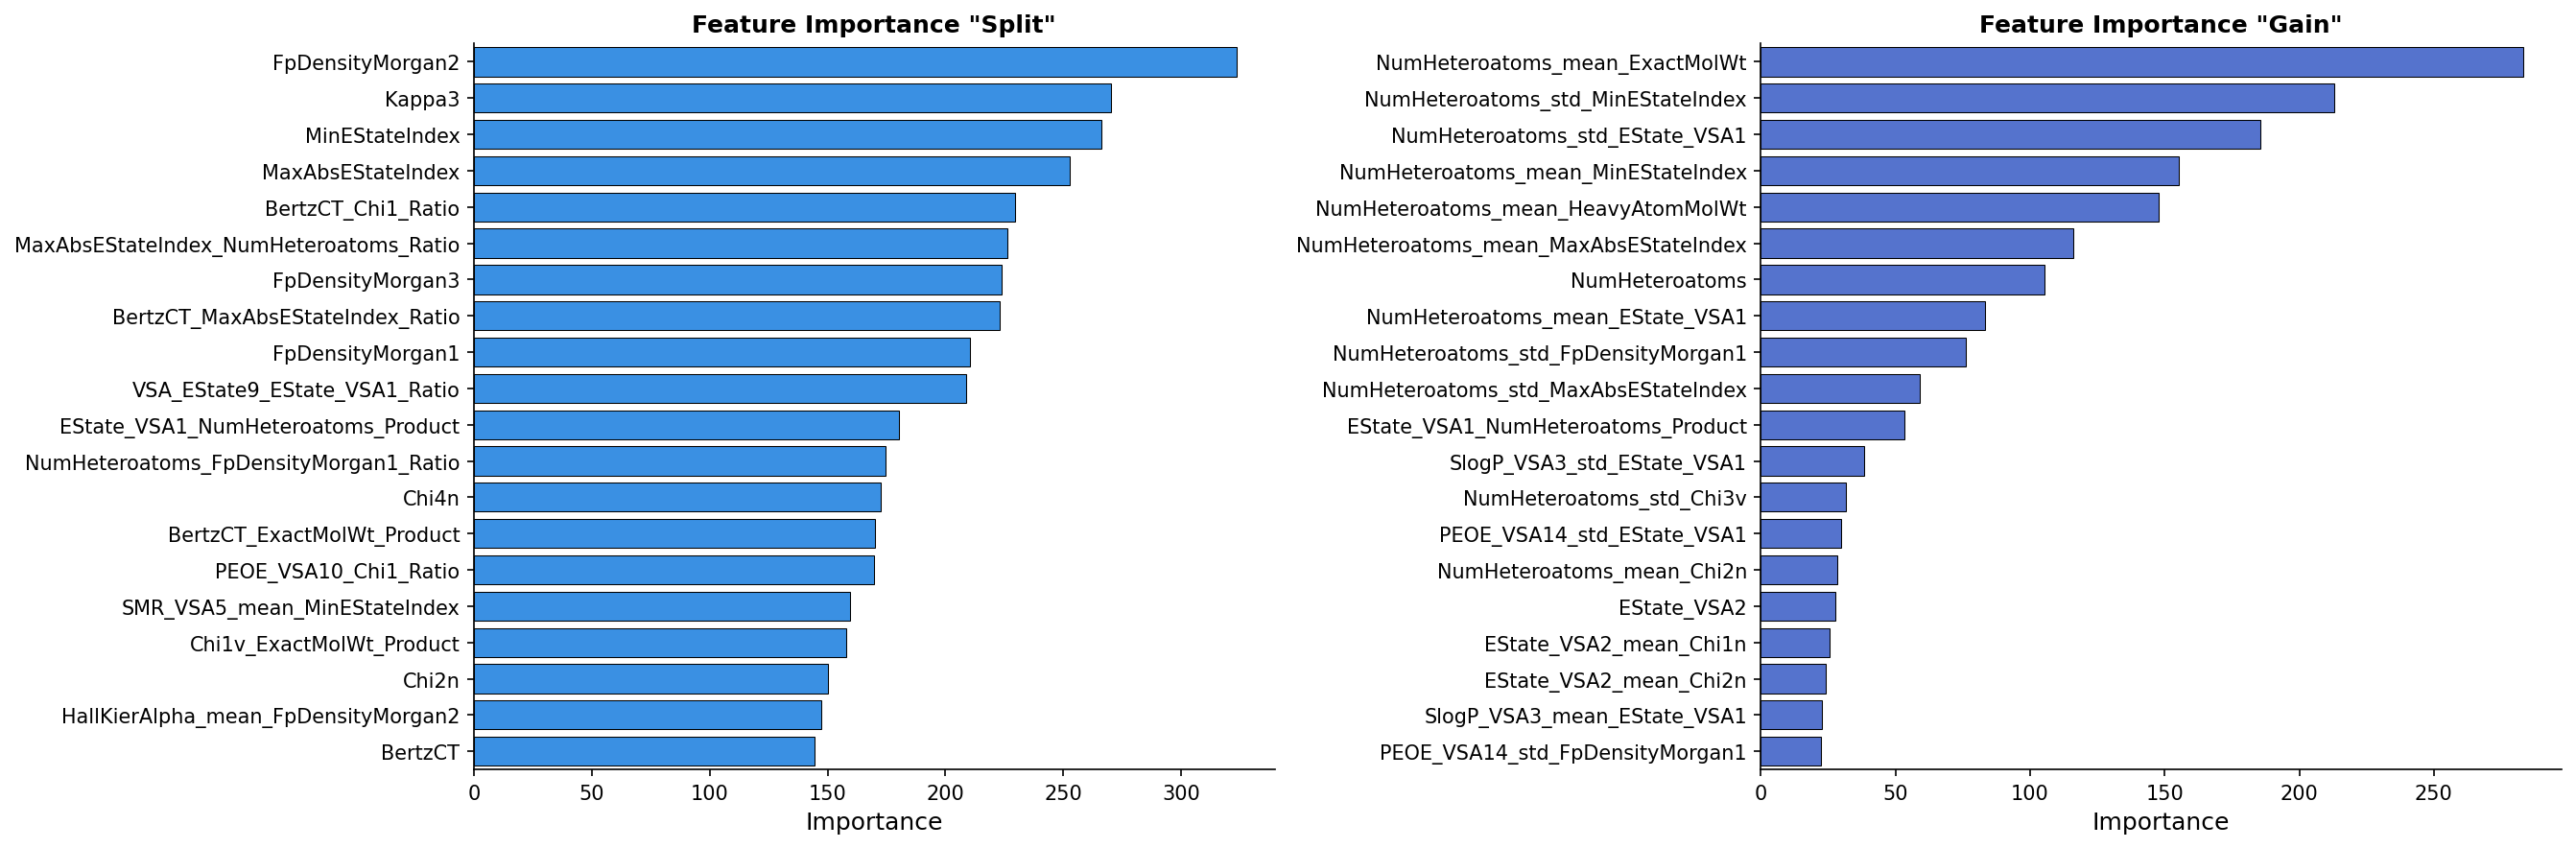

--EC2--
Fold:   0| AUC: 0.60273 | Best iteration:  187
Fold:   1| AUC: 0.62118 | Best iteration:   33
Fold:   2| AUC: 0.59723 | Best iteration:  133
Fold:   3| AUC: 0.59487 | Best iteration:   31
Fold:   4| AUC: 0.57675 | Best iteration:   34
**************************************************
Mean full AUC : 0.56603
Mean val AUC  : 0.65560


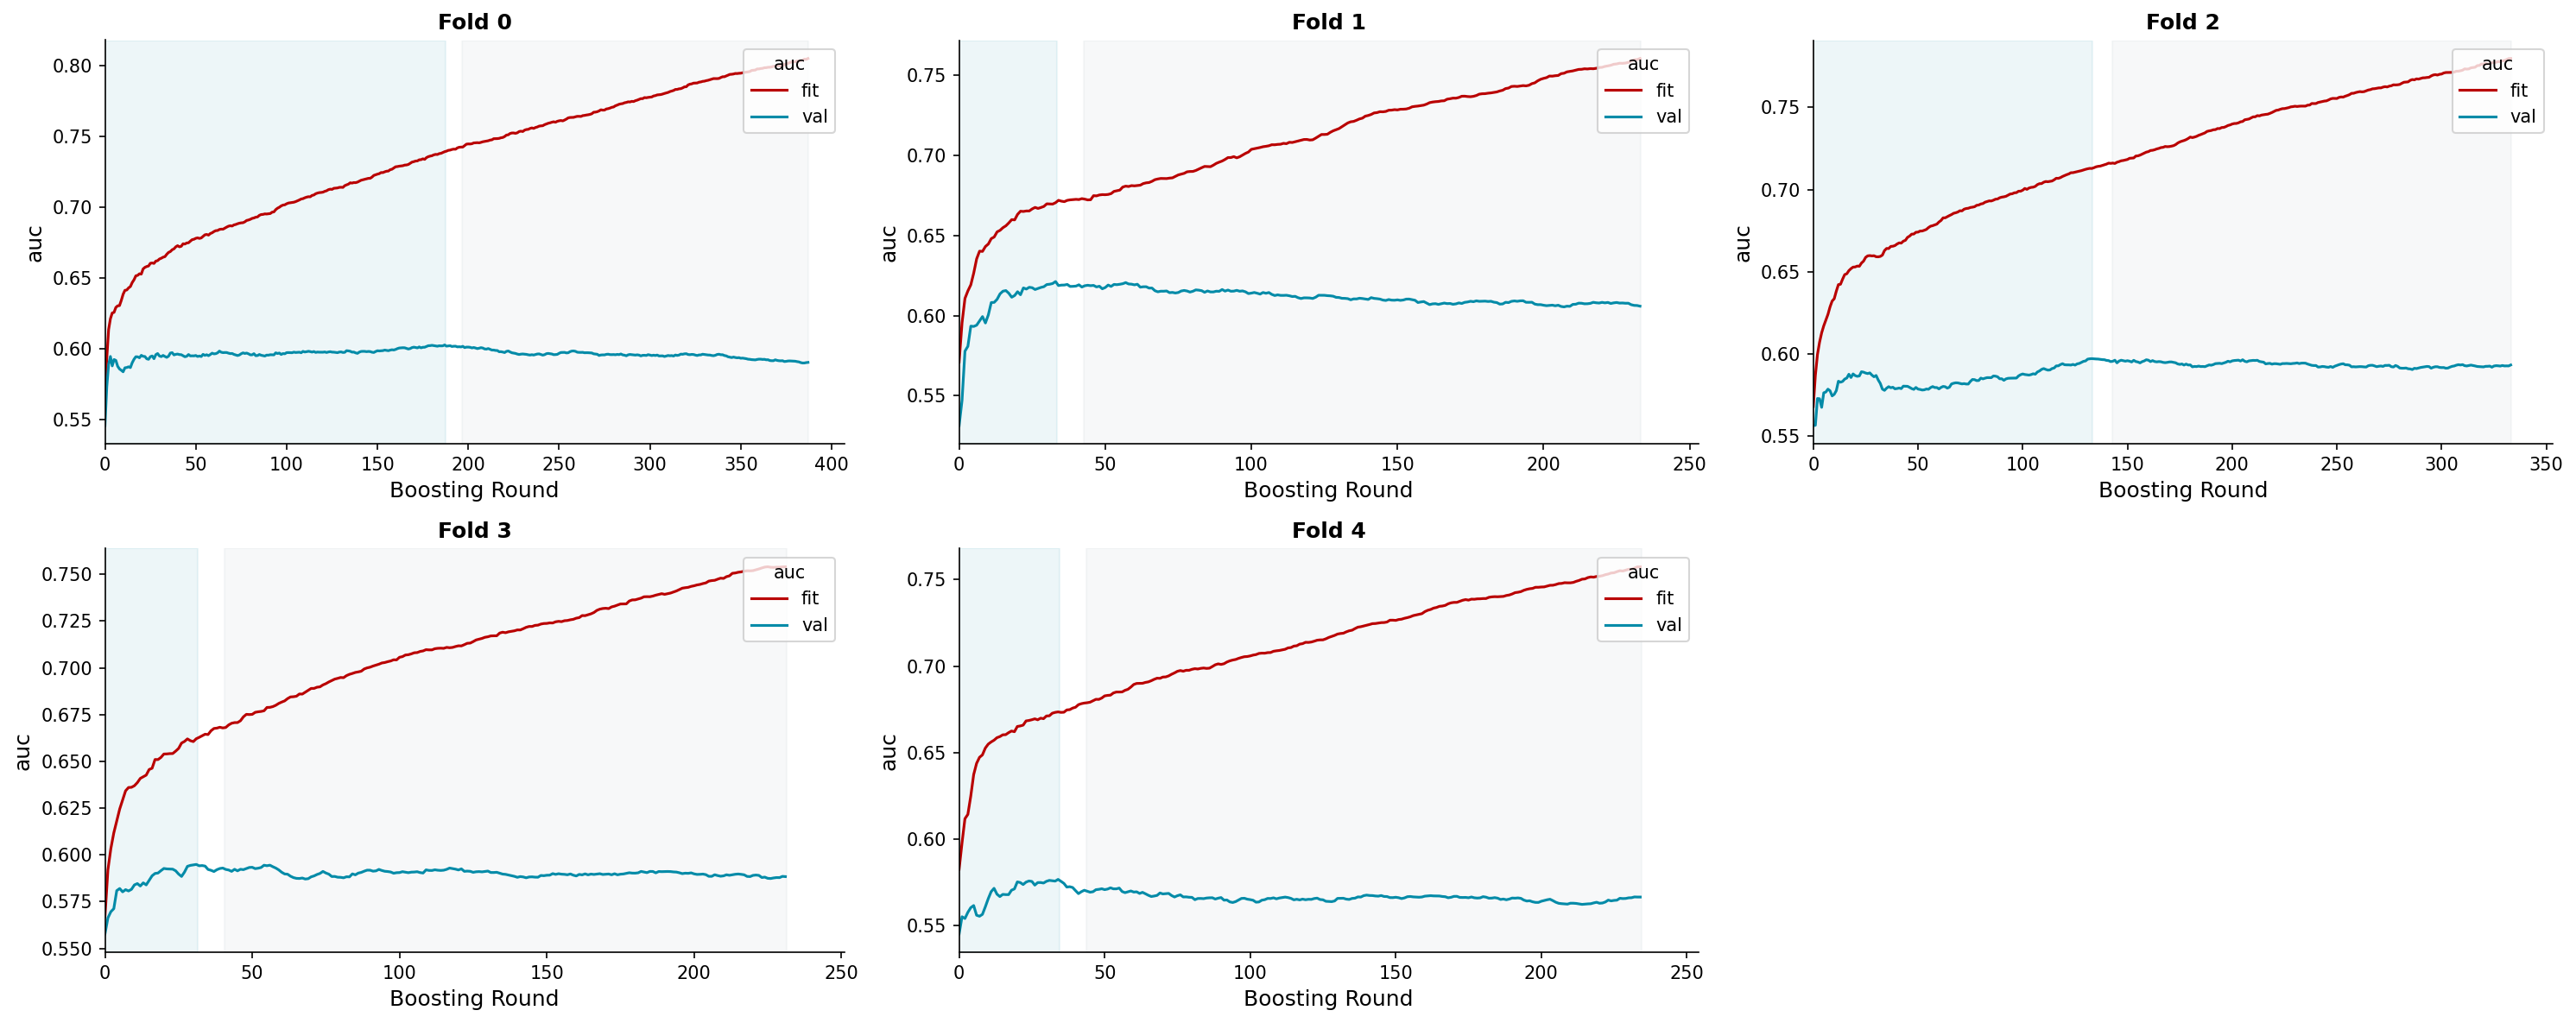

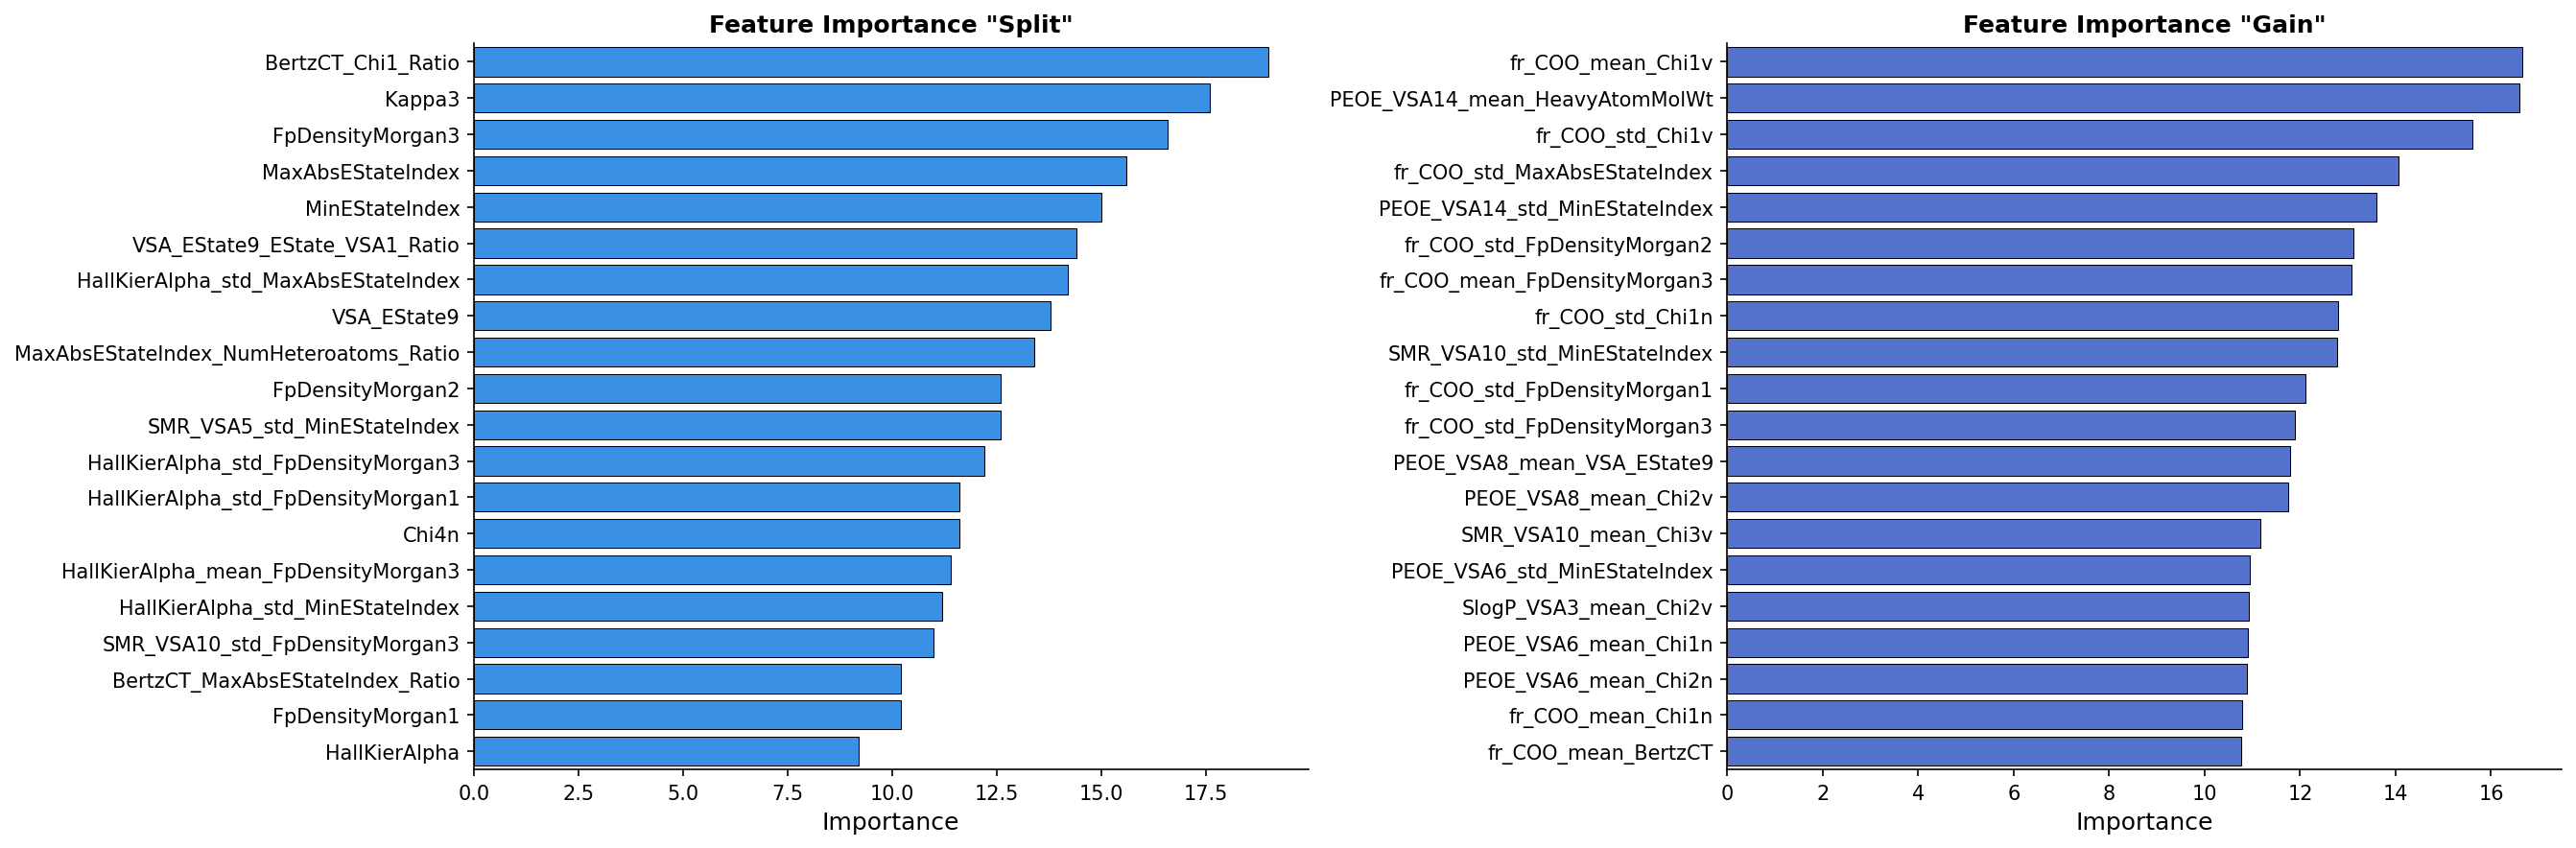

In [14]:
n_estimators_ = 600

test_preds_list = []
val_scores = []
for target_col, X_train, y_train, X_test in zip(target_cols, X_trains, y_trains, X_tests):
    print(f'--{target_col}--')
    # drop_target_col = 'EC2' if target_col == 'EC1' else 'EC1'
    # X_train = X_train.drop(drop_target_col, axis=1)

    feature_importances_ = pd.DataFrame(index=X_train.columns)
    eval_results_ = {}
    best_iters_ = []
    oof = np.zeros((X_train.shape[0]))
    test_preds = np.zeros((X_test.shape[0]))

    splitter = Splitter(kfold=kfold, n_splits=n_splits, cat_df=y_train)
    for i, (X_train_, X_val, y_train_, y_val, val_index) in enumerate(splitter.split_data(X_train, y_train, random_state_list=[0])):
        fold = i % n_splits
        m = i // n_splits

        # XGB .train() requires xgboost.DMatrix.
        # https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.DMatrix
        fit_set = xgb.DMatrix(X_train_, y_train_)
        val_set = xgb.DMatrix(X_val, y_val)
        watchlist = [(fit_set, 'fit'), (val_set, 'val')]

        # Training.
        # https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.training
        classifier = Classifier(target_col, n_estimators_, device)
        xgb_params = classifier.models['xgb'].get_params()
        # xgb_params = xgb.XGBClassifier(n_estimators=3000, learning_rate=0.01).get_params()

        eval_results_[fold] = {}
        model = xgb.train(
            num_boost_round=xgb_params['n_estimators'],
            params=xgb_params,
            dtrain=fit_set,
            evals=watchlist,
            evals_result=eval_results_[fold],
            verbose_eval=False,
            callbacks=[xgb.callback.EarlyStopping(early_stopping_rounds, data_name='val', save_best=True)])

        val_preds = model.predict(val_set)
        test_preds += model.predict(xgb.DMatrix(X_test)) / n_splits

        oof[val_index] = val_preds

        val_score = metric(y_val, val_preds)
        best_iter = model.best_iteration
        best_iters_.append(best_iter)
        val_scores.append(val_score)
        print(f'Fold: {blu}{fold:>3}{res}| {metric_name}: {blu}{val_score:.5f}{res}' f' | Best iteration: {blu}{best_iter:>4}{res}')

        # Stores the feature importances
        feature_importances_[f'gain_{fold}'] = feature_importances_.index.map(model.get_score(importance_type='gain'))
        feature_importances_[f'split_{fold}'] = feature_importances_.index.map(model.get_score(importance_type='weight'))

    # Submission
    sub = pd.read_csv(os.path.join(filepath, 'sample_submission.csv'))
    sub[f'{target_col}'] = test_preds
    sub.to_csv(f'xgb_{target_col}_submission.csv', index=False)
    test_preds_list.append(test_preds) # np.round(test_preds)
    # xgb_test_preds = test_preds.copy()

    mean_cv_score_full = metric(y_train, oof)
    print(f'{"*" * 50}\n{red}Mean full{res} {metric_name} : {red}{mean_cv_score_full:.5f}{res}')
    print(f'{red}Mean val{res} {metric_name}  : {red}{np.mean(val_scores):.5f}{res}')
    
    plot_training_process('auc', eval_results_, best_iters_, early_stopping_rounds)
    plot_feature_importance(feature_importances_)


Weighted Ensemble Model by Optuna on Training

A weighted average is performed during training;
The weights were determined for each model using the predictions for the train data created in the out of fold with Optuna's CMAsampler. (Here it is defined by OptunaWeights)
This is an extension of the averaging method. All models are assigned different weights defining the importance of each model for prediction.



In [15]:
class OptunaWeights:
    def __init__(self, random_state, n_trials=100):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 1e-15, 1) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)

        # Calculate the score for the weighted prediction
        score = metric(y_true, weighted_pred)
        return score

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        pruner = optuna.pruners.HyperbandPruner()
        self.study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights", direction='maximize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

In [16]:
%%time

test_predss_list = []
oof_predss_list = []
ensemble_score_list = []
weights_list = []
trained_models_list = []
score_dict_list = []
X_val_list = []
oof_preds_list = []

for target_col, X_train, y_train, X_test in zip(target_cols, X_trains, y_trains, X_tests):
    print(f'=== {target_col} ===')
    # drop_target_col = 'EC2' if target_col == 'EC1' else 'EC1'
    # X_train = X_train.drop(drop_target_col, axis=1)

    # Initialize an array for storing test predictions
    classifier = Classifier(target_col, n_estimators, device, random_state)
    test_predss = np.zeros((X_test.shape[0]))
    oof_predss = np.zeros((X_train.shape[0], n_reapts))
    ensemble_score, ensemble_score_ = [], []
    weights = []
    trained_models = dict(zip([_ for _ in classifier.models_name if ('xgb' in _) or ('lgb' in _) or ('cat' in _)], [[] for _ in range(classifier.len_models)]))
    score_dict = dict(zip(classifier.models_name, [[] for _ in range(classifier.len_models)]))

    splitter = Splitter(kfold=kfold, n_splits=n_splits, cat_df=y_train)
    for i, (X_train_, X_val, y_train_, y_val, val_index) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
        n = i % n_splits
        m = i // n_splits

        # Get a set of classifier models
        classifier = Classifier(target_col, n_estimators, device, random_state_list[m])
        models = classifier.models

        # Initialize lists to store oof and test predictions for each base model
        oof_preds = []
        test_preds = []

        # Loop over each base model and fit it to the training data, evaluate on validation data, and store predictions
        for name, model in models.items():
            best_iteration = None
            start_time = time.time()

            if ('xgb' in name) or ('lgb' in name) or ('cat' in name):
                early_stopping_rounds_ = int(early_stopping_rounds*2) if ('lgb' in name) else early_stopping_rounds

                if 'lgb' in name:
                    model.fit(
                        X_train_, y_train_, eval_set=[(X_val, y_val)], categorical_feature=cat_cols,
                        early_stopping_rounds=early_stopping_rounds_, verbose=verbose)
                elif 'cat' in name :
                    model.fit(
                        Pool(X_train_, y_train_, cat_features=cat_cols), eval_set=Pool(X_val, y_val, cat_features=cat_cols),
                        early_stopping_rounds=early_stopping_rounds_, verbose=verbose)
                else:
                    model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], early_stopping_rounds=early_stopping_rounds_, verbose=verbose)

                best_iteration = model.best_iteration if ('xgb' in name) else model.best_iteration_
            else:
                model.fit(X_train_, y_train_)

            end_time = time.time()
            min_, sec = sec_to_minsec(end_time - start_time)

            if name in trained_models.keys():
                trained_models[f'{name}'].append(deepcopy(model))

            y_val_pred = model.predict_proba(X_val)[:, 1].reshape(-1)
            test_pred = model.predict_proba(X_test)[:, 1].reshape(-1)

            score = metric(y_val, y_val_pred)
            score_dict[name].append(score)
            print(f'{blu}{name}{res} [FOLD-{n} SEED-{random_state_list[m]}] {metric_name} {blu}{score:.5f}{res} | Best iteration {blu}{best_iteration}{res} | Runtime {min_}min {sec}s')

            oof_preds.append(y_val_pred)
            test_preds.append(test_pred)

        # Use Optuna to find the best ensemble weights
        optweights = OptunaWeights(random_state=random_state_list[m], n_trials=n_trials)
        y_val_pred = optweights.fit_predict(y_val.values, oof_preds)

        score = metric(y_val, y_val_pred)
        print(f'{red}>>> Ensemble{res} [FOLD-{n} SEED-{random_state_list[m]}] {metric_name} {red}{score:.5f}{res}')
        print(f'{"-" * 60}')
        ensemble_score.append(score)
        weights.append(optweights.weights)

        # Predict to X_test by the best ensemble weights
        test_predss += optweights.predict(test_preds) / (n_splits * len(random_state_list))
        oof_predss[X_val.index, m] += optweights.predict(oof_preds)

        gc.collect()
        
    test_predss_list.append(test_predss)
    oof_predss_list.append(oof_predss)
    ensemble_score_list.append(ensemble_score)
    weights_list.append(weights)
    trained_models_list.append(trained_models)
    score_dict_list.append(score_dict)
    X_val_list.append(X_val)
    oof_preds_list.append(oof_preds)

=== EC1 ===
xgb [FOLD-0 SEED-1824] AUC 0.71040 | Best iteration 238 | Runtime 0min 48s
lgb [FOLD-0 SEED-1824] AUC 0.71181 | Best iteration 55 | Runtime 0min 10s
cat [FOLD-0 SEED-1824] AUC 0.71280 | Best iteration 347 | Runtime 0min 14s
lgb2 [FOLD-0 SEED-1824] AUC 0.71352 | Best iteration 136 | Runtime 0min 10s
hgb [FOLD-0 SEED-1824] AUC 0.70937 | Best iteration None | Runtime 0min 3s
rfc [FOLD-0 SEED-1824] AUC 0.69474 | Best iteration None | Runtime 0min 20s
lrc [FOLD-0 SEED-1824] AUC 0.70600 | Best iteration None | Runtime 0min 2s
mlp [FOLD-0 SEED-1824] AUC 0.70141 | Best iteration None | Runtime 0min 8s
ada [FOLD-0 SEED-1824] AUC 0.69992 | Best iteration None | Runtime 0min 23s
>>> Ensemble [FOLD-0 SEED-1824] AUC 0.71640
------------------------------------------------------------
xgb [FOLD-1 SEED-1824] AUC 0.72227 | Best iteration 410 | Runtime 1min 6s
lgb [FOLD-1 SEED-1824] AUC 0.72329 | Best iteration 59 | Runtime 0min 10s
cat [FOLD-1 SEED-1824] AUC 0.72448 | Best iteration 226 | 

Mean Scores for each model

=== EC1 ===
--- Mean AUC Scores---
xgb: 0.71505 ± 0.00682
lgb: 0.71611 ± 0.00636
cat: 0.71694 ± 0.00573
lgb2: 0.71726 ± 0.00574
hgb: 0.71494 ± 0.00593
rfc: 0.69876 ± 0.00736
lrc: 0.70323 ± 0.00731
mlp: 0.69408 ± 0.00758
ada: 0.69958 ± 0.00597


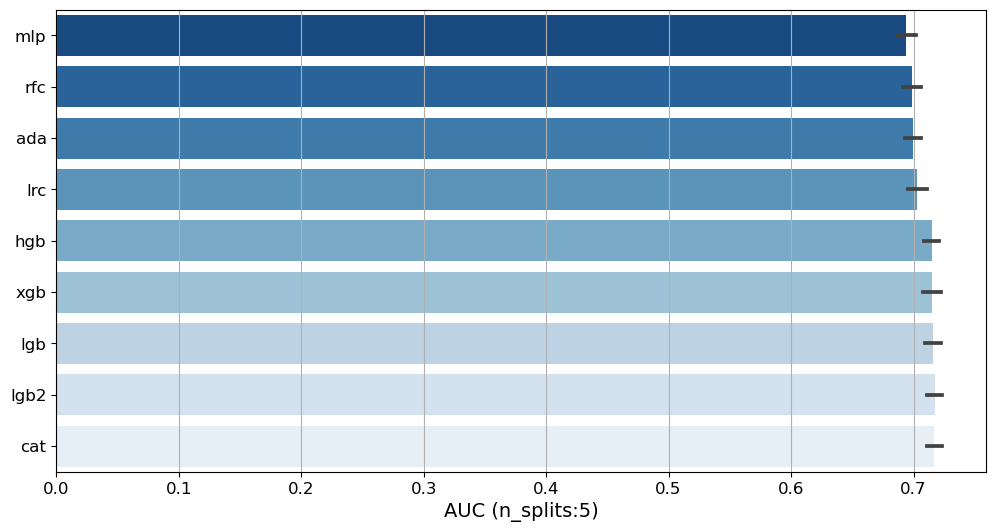

=== EC2 ===
--- Mean AUC Scores---
xgb: 0.59687 ± 0.00951
lgb: 0.59384 ± 0.00799
cat: 0.59437 ± 0.00837
xgb2: 0.59586 ± 0.00858
lgb2: 0.59517 ± 0.00758
cat2: 0.59115 ± 0.00810
hgb: 0.58541 ± 0.00952
rfc: 0.57150 ± 0.00858
lrc: 0.57308 ± 0.00891
etc: 0.56672 ± 0.01051
mlp: 0.55215 ± 0.02122
ada: 0.57420 ± 0.01215


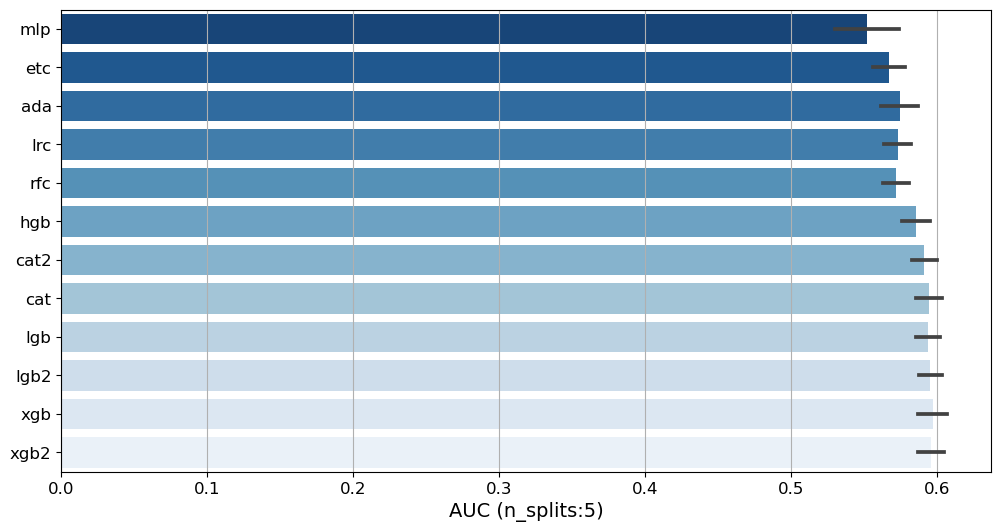

In [17]:
def plot_score_from_dict(score_dict, title='', ascending=True):
    score_df = pd.melt(pd.DataFrame(score_dict))
    score_df = score_df.sort_values('value', ascending=ascending)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='value', y='variable', data=score_df, palette='Blues_r', errorbar='sd')
    plt.xlabel(f'{title}', fontsize=14)
    plt.ylabel('')
    #plt.title(f'{title}', fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, axis='x')
    plt.show()

for target_col, score_dict in zip(target_cols, score_dict_list):
    print(f'=== {target_col} ===') 
    print(f'--- Mean {metric_name} Scores---')    
    for name, score in score_dict.items():
        mean_score = np.mean(score)
        std_score = np.std(score)
        print(f'{name}: {red}{mean_score:.5f} ± {std_score:.5f}{res}')
    plot_score_from_dict(score_dict, title=f'{metric_name} (n_splits:{n_splits})')

Weight of the Optuna Ensemble

=== EC1 ===
Mean Optuna Ensemble AUC 0.72024 ± 0.00584

--- Optuna Weights---
xgb: 0.33926 ± 0.40872
lgb: 0.37802 ± 0.32511
cat: 0.51374 ± 0.34687
xgb2: 0.63234 ± 0.30648
lgb2: 0.32946 ± 0.38866
cat2: 0.08877 ± 0.13839
hgb: 0.24300 ± 0.27406
rfc: 0.12503 ± 0.14576
lrc: 0.44906 ± 0.31376


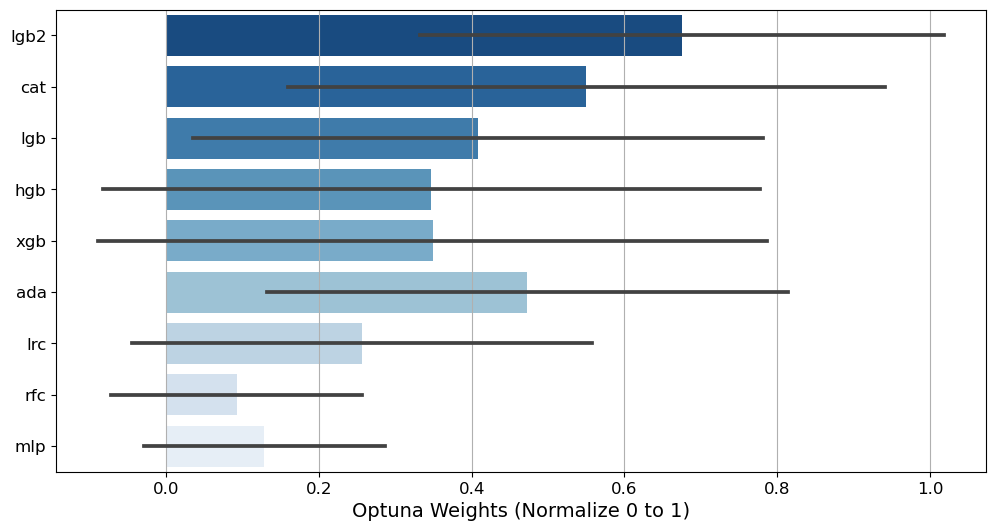

NameError: name 'linkage' is not defined

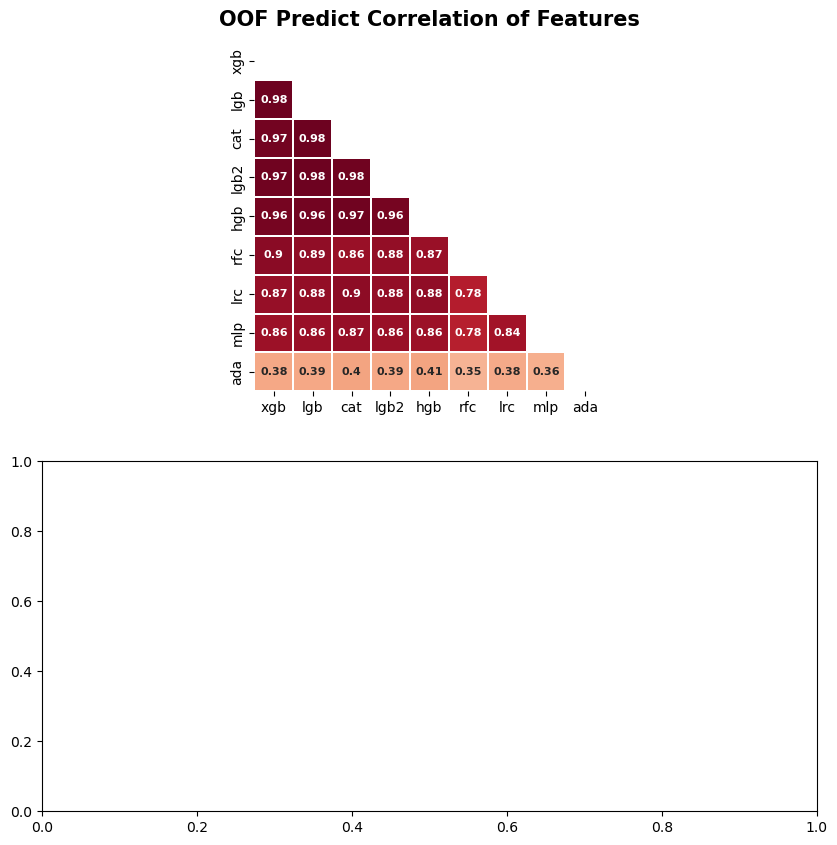

In [18]:
def plot_heatmap_with_dendrogram(df, title, figsize=(18, 10), fontsize=10):
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True

    colormap = plt.cm.RdBu_r
    fig, ax = plt.subplots(2, 1, figsize=figsize)

    # Plot heatmap
    ax[0].set_title(f'{title} Correlation of Features', fontweight='bold', y=1.02, size=15)
    sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1.0,
                square=True, cmap=colormap, linecolor='white', annot=True,
                annot_kws={"size": fontsize, "weight": "bold"}, mask=mask, ax=ax[0], cbar=False)

    # Plot dendrogram
    correlations = df.corr()
    converted_corr = 1 - np.abs(correlations)
    Z = linkage(squareform(converted_corr), 'complete')
    
    dn = dendrogram(Z, labels=df.columns, above_threshold_color='#ff0000', ax=ax[1])
    ax[1].set_title(f'{title} Hierarchical Clustering Dendrogram', fontsize=15, fontweight='bold')
    ax[1].grid(axis='x')
    ax[1].tick_params(axis='x', rotation=90)
    ax[1].tick_params(axis='y', labelsize=fontsize)

    plt.tight_layout()
    plt.show()

for target_col, ensemble_score, weights, oof_preds, score_dict in zip(target_cols, ensemble_score_list, weights_list, oof_preds_list, score_dict_list):
    print(f'=== {target_col} ===') 

    # Calculate the mean LogLoss score of the ensemble
    mean_score = np.mean(ensemble_score)
    std_score = np.std(ensemble_score)
    print(f'{red}Mean{res} Optuna Ensemble {metric_name} {red}{mean_score:.5f} ± {std_score:.5f}{res}')

    print('')
    # Print the mean and standard deviation of the ensemble weights for each model
    print('--- Optuna Weights---')
    mean_weights = np.mean(weights, axis=0)
    std_weights = np.std(weights, axis=0)
    for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
        print(f'{name}: {blu}{mean_weight:.5f} ± {std_weight:.5f}{res}')

    # Plot Optuna Weights
    normalize = [((weight - np.min(weight)) / (np.max(weight) - np.min(weight))).tolist() for weight in weights]
    weight_dict = dict(zip(list(score_dict.keys()), np.array(normalize).T.tolist()))
    plot_score_from_dict(weight_dict, title='Optuna Weights (Normalize 0 to 1)', ascending=False)
    
    # Plot oof_predict analyis for each model
    plot_heatmap_with_dendrogram(pd.DataFrame(oof_preds, index=list(score_dict.keys())).T, title='OOF Predict', figsize=(10, 10), fontsize=8)

mean_score = np.mean(ensemble_score_list)
std_score = np.std(ensemble_score_list)
print(f'{red} EC1 and EC2 Mean{res} Optuna Ensemble {metric_name} {red}{mean_score:.5f} ± {std_score:.5f}{res}')


Xgboost EC1

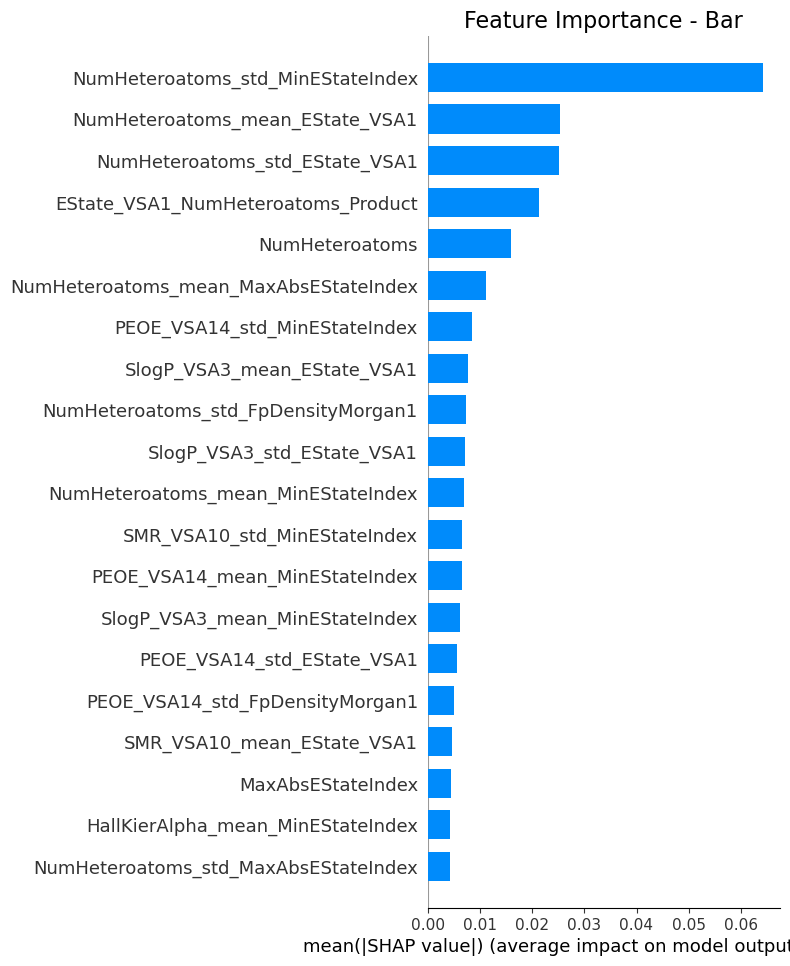

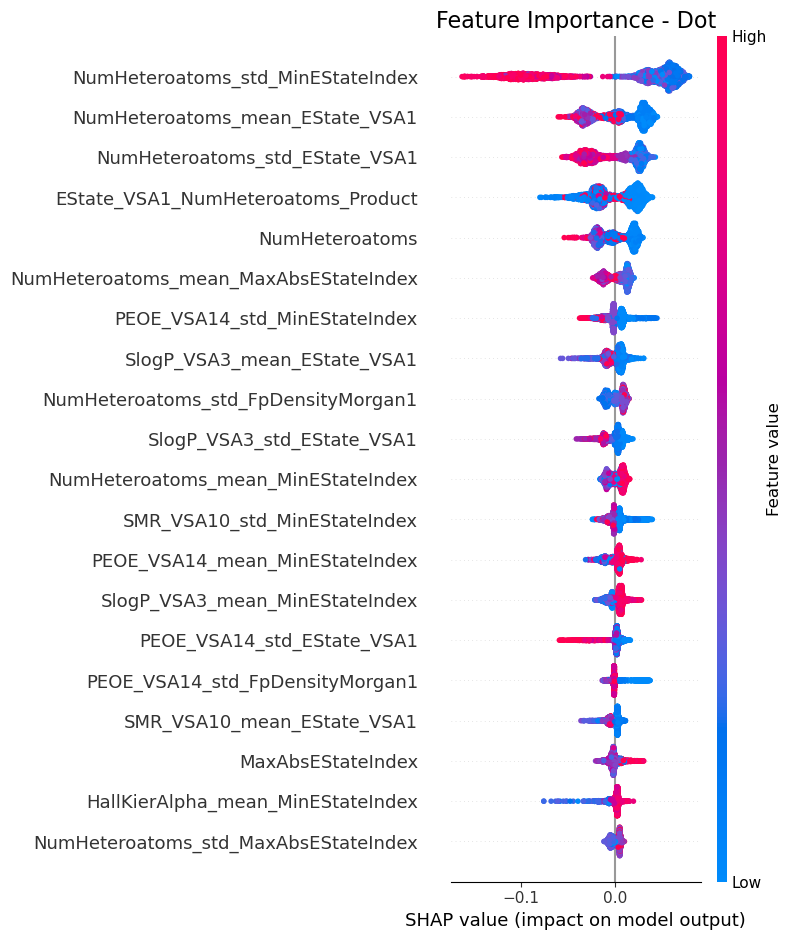

In [19]:
shap.initjs()
explainer = shap.TreeExplainer(model=trained_models_list[0]['xgb'][-1])
shap_values = explainer.shap_values(X=X_val_list[0])

# Bar plot
plt.figure(figsize=(20, 14))
shap.summary_plot(shap_values, X_val_list[0], plot_type="bar", show=False)
plt.title("Feature Importance - Bar", fontsize=16)

# Dot plot
plt.figure(figsize=(20, 14))
shap.summary_plot(shap_values, X_val_list[0], plot_type="dot", show=False)
plt.title("Feature Importance - Dot", fontsize=16)

# Adjust layout and display the plots side by side
plt.tight_layout()
plt.show()

Catboost EC1

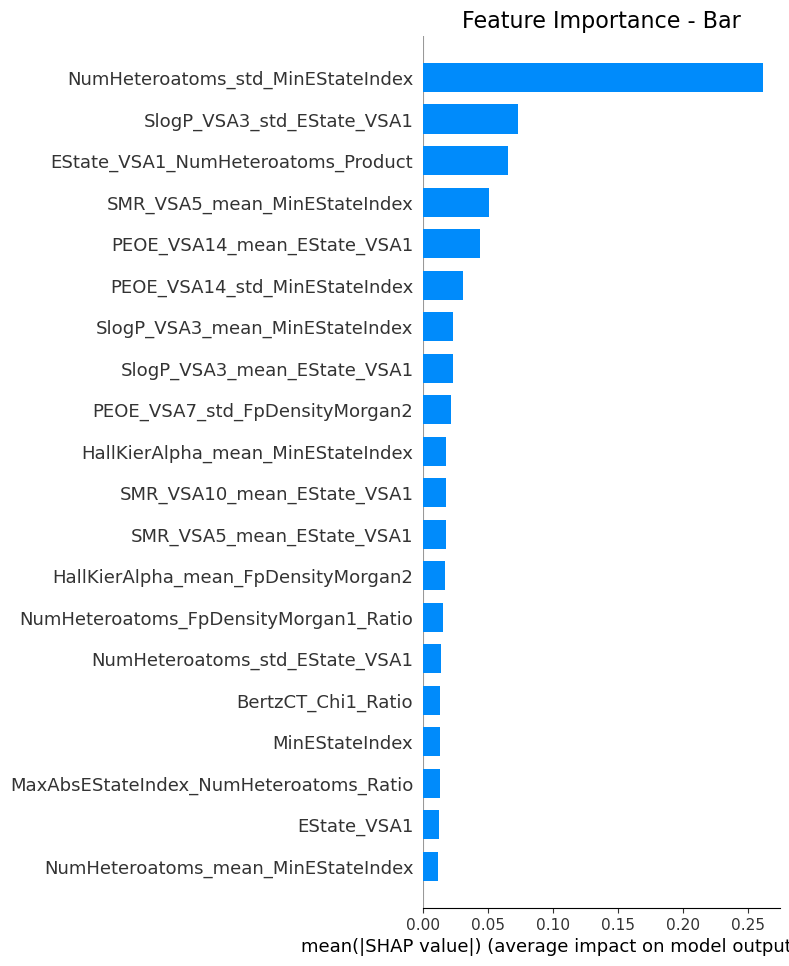

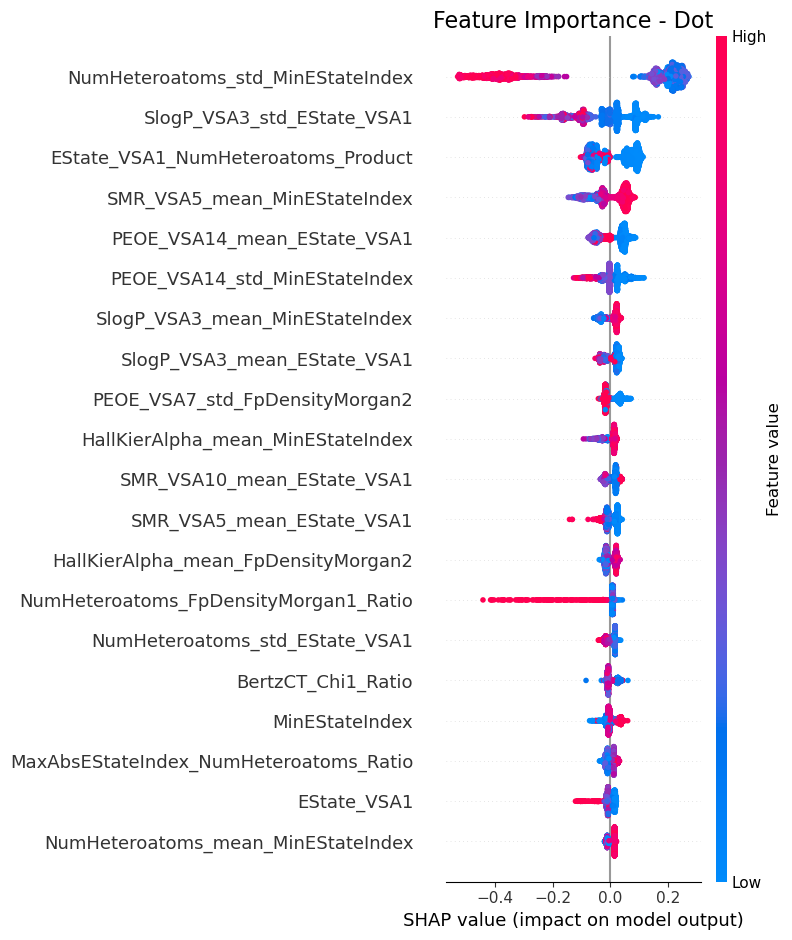

In [20]:
shap.initjs()
explainer = shap.TreeExplainer(model=trained_models_list[0]['cat'][-1])
shap_values = explainer.shap_values(X=X_val_list[0])

# Bar plot
plt.figure(figsize=(20, 14))
shap.summary_plot(shap_values, X_val_list[0], plot_type="bar", show=False)
plt.title("Feature Importance - Bar", fontsize=16)

# Dot plot
plt.figure(figsize=(20, 14))
shap.summary_plot(shap_values, X_val_list[0], plot_type="dot", show=False)
plt.title("Feature Importance - Dot", fontsize=16)

# Adjust layout and display the plots side by side
plt.tight_layout()
plt.show()

Xgboost EC2

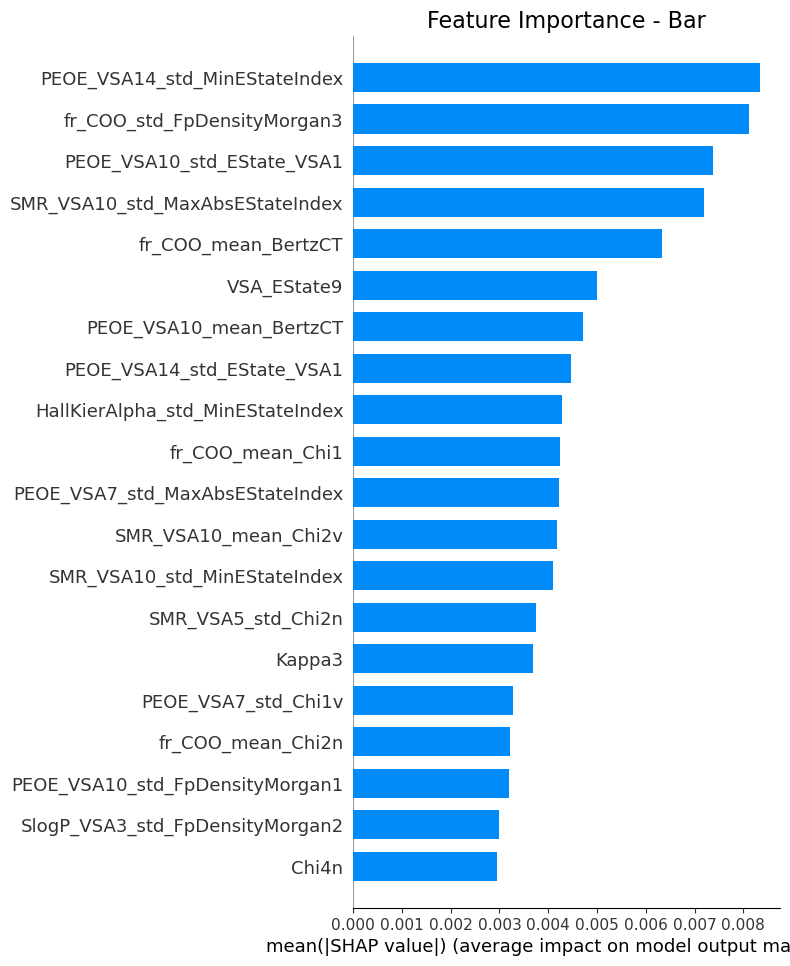

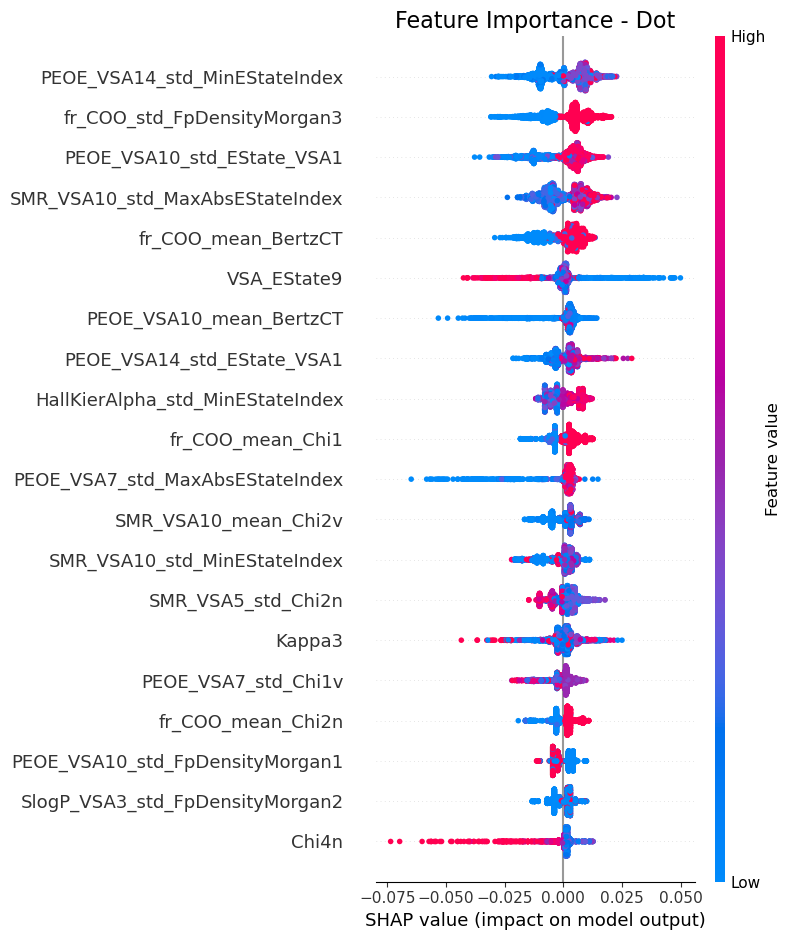

In [21]:
shap.initjs()
explainer = shap.TreeExplainer(model=trained_models_list[1]['xgb'][-1])
shap_values = explainer.shap_values(X=X_val_list[1])

# Bar plot
plt.figure(figsize=(20, 14))
shap.summary_plot(shap_values, X_val_list[1], plot_type="bar", show=False)
plt.title("Feature Importance - Bar", fontsize=16)

# Dot plot
plt.figure(figsize=(20, 14))
shap.summary_plot(shap_values, X_val_list[1], plot_type="dot", show=False)
plt.title("Feature Importance - Dot", fontsize=16)

# Adjust layout and display the plots side by side
plt.tight_layout()
plt.show()

Catboost EC2

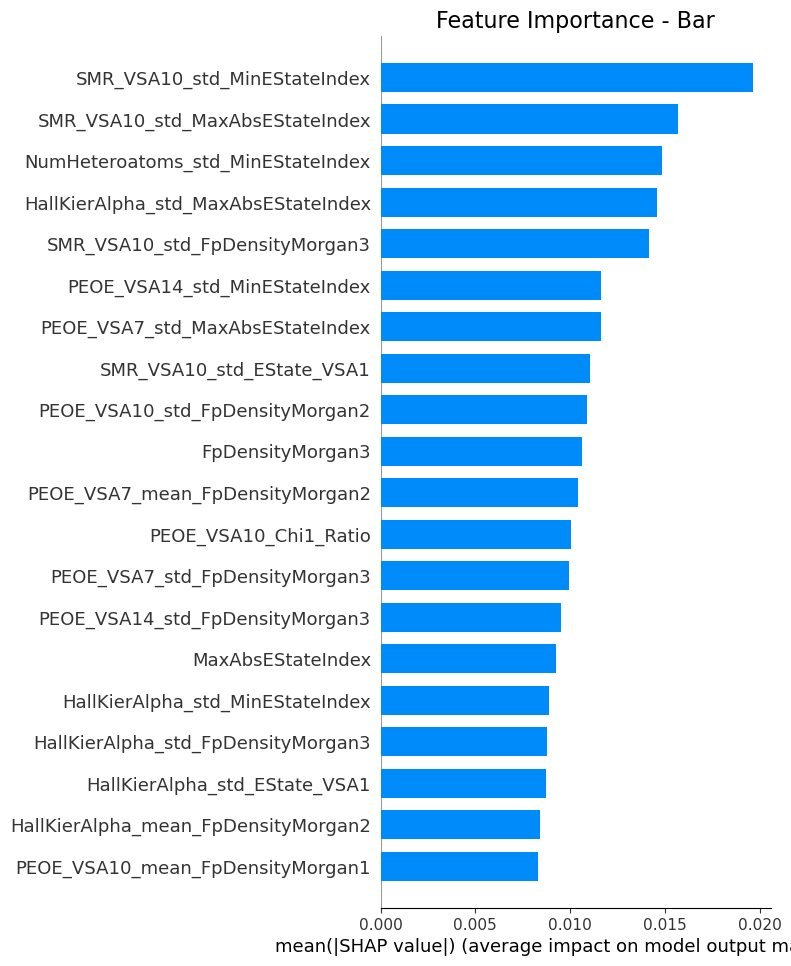

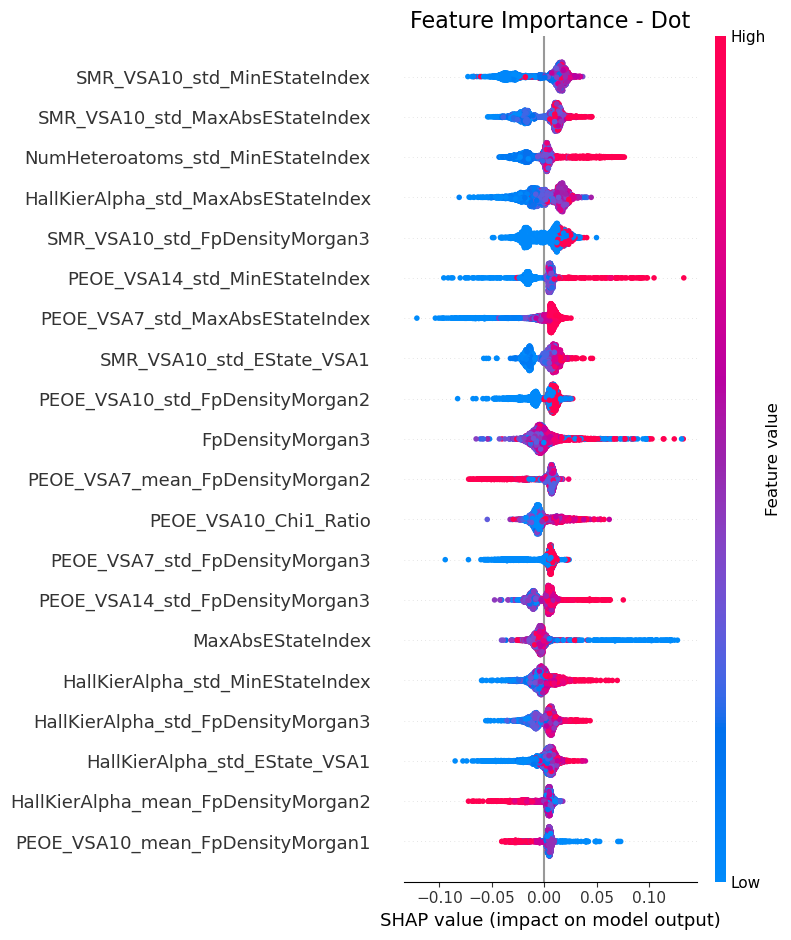

In [22]:
shap.initjs()
explainer = shap.TreeExplainer(model=trained_models_list[1]['cat'][-1])
shap_values = explainer.shap_values(X=X_val_list[1])

# Bar plot
plt.figure(figsize=(20, 14))
shap.summary_plot(shap_values, X_val_list[1], plot_type="bar", show=False)
plt.title("Feature Importance - Bar", fontsize=16)

# Dot plot
plt.figure(figsize=(20, 14))
shap.summary_plot(shap_values, X_val_list[1], plot_type="dot", show=False)
plt.title("Feature Importance - Dot", fontsize=16)

# Adjust layout and display the plots side by side
plt.tight_layout()
plt.show()


Make Submission

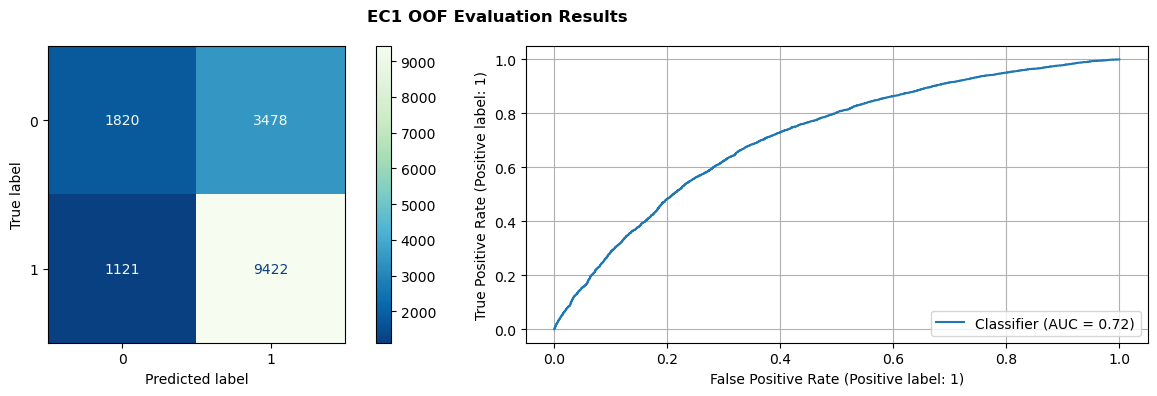

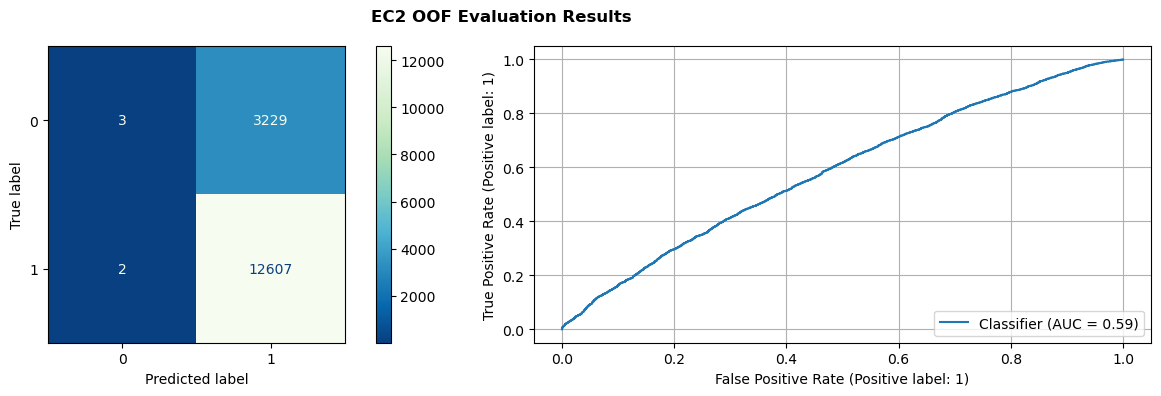

In [23]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def show_confusion_roc(oof, title='Model Evaluation Results'):
    f, ax = plt.subplots(1, 2, figsize=(13.3, 4))
    df = pd.DataFrame(np.stack([oof[0], oof[1]]), index=['preds', 'target']).T
    cm = confusion_matrix(df.target, df.preds.ge(0.5).astype(int))
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='GnBu_r', ax=ax[0])
    ax[0].grid(False)
    RocCurveDisplay.from_predictions(df.target, df.preds, ax=ax[1])
    ax[1].grid(True)
    plt.suptitle(f'{title}', fontsize=12, fontweight='bold')
    plt.tight_layout()
    #plt.grid()

for target_col, y_train, oof_predss in zip(target_cols, y_trains, oof_predss_list):
    show_confusion_roc(oof=[np.mean(oof_predss, axis=1), y_train], title=f'{target_col} OOF Evaluation Results')


In [24]:
def make_submission(target_cols, test_predss_list, prefix=''):
    sub = pd.read_csv(os.path.join(filepath, 'sample_submission.csv'))
    for target_col, test_predss in zip(target_cols, test_predss_list):
        sub[f'{target_col}'] = test_predss
    sub.to_csv(f'{prefix}submission.csv', index=False)
    return  sub

sub = make_submission(target_cols, test_predss_list, prefix='')
sub

id       EC1       EC2
0     14838  0.489141  0.727681
1     14839  0.746875  0.736614
2     14840  0.742914  0.726790
3     14841  0.703976  0.740338
4     14842  0.684081  0.730950
...     ...       ...       ...
9888  24726  0.577095  0.719503
9889  24727  0.737070  0.757863
9890  24728  0.365704  0.745674
9891  24729  0.522618  0.753753
9892  24730  0.396875  0.762807

[9893 rows x 3 columns]

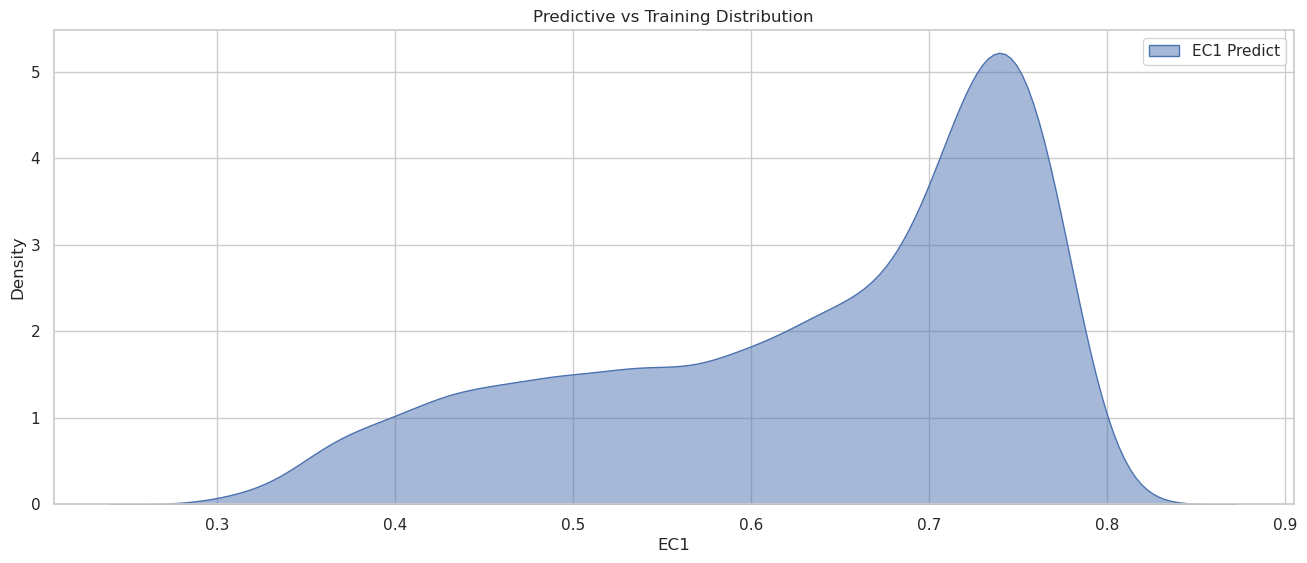

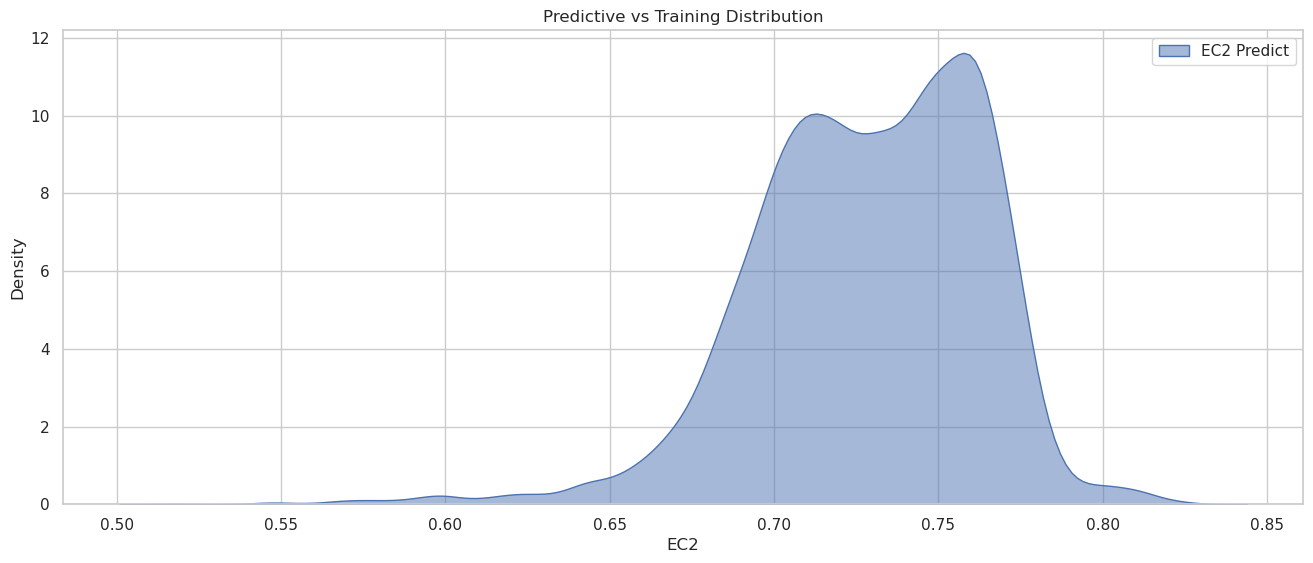

In [25]:
def plot_distribution(filepath, sub, target_col):
    # df_train = pd.read_csv(os.path.join(filepath, 'train.csv'), index_col=[0])
    # df_test = pd.read_csv(os.path.join(filepath, 'test.csv'), index_col=[0])
    # original = pd.read_csv('/kaggle/input/machine-failure-predictions/machine failure.csv', index_col=[0])

    plt.figure(figsize=(16, 6))
    sns.set_theme(style="whitegrid")

    sns.kdeplot(data=sub, x=target_col, fill=True, alpha=0.5, common_norm=False, label=f"{target_col} Predict")
    # sns.kdeplot(data=df_train, x=target_col, fill=True, alpha=0.5, common_norm=False, label="Data")
    # sns.kdeplot(data=original, x=target_col, fill=True, alpha=0.5, common_norm=False, label="Original")

    plt.title('Predictive vs Training Distribution')
    plt.legend()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
for target_col in target_cols:
    plot_distribution(filepath, sub, target_col)
